# $\textbf{Part 1. Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

#### $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

#### $\textbf{Prediction of LFSR State }n + 1\textbf{ Given State }n$
$\text{Suppose we are given an arbitrary LFSR feedback polynomial and we build a representation of the LFSR in software. Using this LFSR, and}$
$\text{assuming the feedback polynomial is primitive in a polynomial ring of fixed degree over }GF(2)\text{, we can generate a maximum-length binary}$
$\text{sequence which has well-documented correlation properties which make them desirable building blocks for stream ciphers or spread-spectrum}$
$\text{codes, to name a few examples. On their own, LFSRs do not afford any real cryptographic protection, being famously susceptible to correlation}$
$\text{attacks. Speaking of attacks, our goal in this notebook is to demonstrate that we can use a }\textit{very}\text{ simple neural network to predict LFSR behavior.}$
$\text{Specifically, we posit that a two-layer (i.e., single hidden-layer) feedforward neural network can readily predict the state-evolution of an arbitrary}$
$\text{LFSR. For simplicity, we constrain this network to have a very specific architecture. Its input layer consists of a fixed-length binary vector that}$
$\text{represents the LFSR state vector at some time index (epoch) }n\text{. We use the ground truth register state at index / epoch }n + 1\text{ to train a the network}$
$\text{to develop a latent representation of the finite field recursion. Both layers of the network are sigmoid connections, representing soft approximations}$
$\text{of boolean gates, outputing activations in the unit interval, }[0,1].\text{ These layers assume no bias terms, only weighted combinations of inputs. For}$
$\text{an LFSR of recursion-order/polynomial degree }deg\text{, the first (and only) hidden layer consists a total of }deg + 2\text{ weighted sigmoidal activations.}$
$\text{The output layer consists of the }deg\text{ total activations predicting }deg\text{ total bits in the LFSR state vector at epoch }n + 1\text{, for all }n\text{. These binary}$
$\text{activations are trained against the true LFSR state vectors at these indices }n + 1\text{ using a binary cross-entropy error function. The population of}$
$\text{observations are the }deg\text{-length LFSR states across all epochs in one full }m\text{-sequence period / cycle. The labels for the error function are the }$
$deg\text{-length state vector values upon 1 iteration of the LFSR recursion, per observation.}$

#### $\textbf{Part 1 of This Notebook}$
$\text{Part 1 of this notebook prototypes a feedforward binary (bias-less) neural network using Keras, training it as described above using RMSprop. The}$
$\text{model is given too few degrees of freedom to completely memorize the bits, so it must learn a latent representation of the underlying finite field}$
$\text{mathematics defining the recurrence relation. After sufficiently many training epochs, the model has been tested to converge to 100}\%\text{ accuracy}$
$\text{for all degree-10 primitive polynomials in the file 10.txt. Primitive polynomials defining }m\text{-sequences for other polynomial degrees are available}$
$\text{for download at the following site: }\textit{https://users.ece.cmu.edu/~koopman/lfsr/index.html}\text{. Future efforts may build this proof-of-concept out to}$
$\text{higher degree recursions and more complicated kinds of stream ciphers. For now, we demonstrate that a relatively shallow binary network is}$
$\text{sufficiently powerful to "crack" (i.e., predict) an LFSR's underlying recursive state vector mapping.}$

$\text{In addition to training the network, we animate the results in a plot which depicts the time-evolution of the LFSR recursion and the neural}$
$\text{network's state predictions. In addition, options are provided for plotting the correlation properties of the }m\text{-sequence training data and the Keras}$
$\text{model metrics vs training epoch, respectively. Documentation and source code for all the functions below can be found in this repo's modules.}$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max, roll

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 16 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 20000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

# Turn ON/OFF true vs. predicted mask plot
plot_prediction_masks = True

# Turn ON/OFF tapped vs. normal LFSR state observations
enable_tapped_register_obs = False

# Turn ON/OFF visualzation of metrics vs. training epoch
plot_metrics_versus_epoch = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg,
    path='./primitive_polynomials/')

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


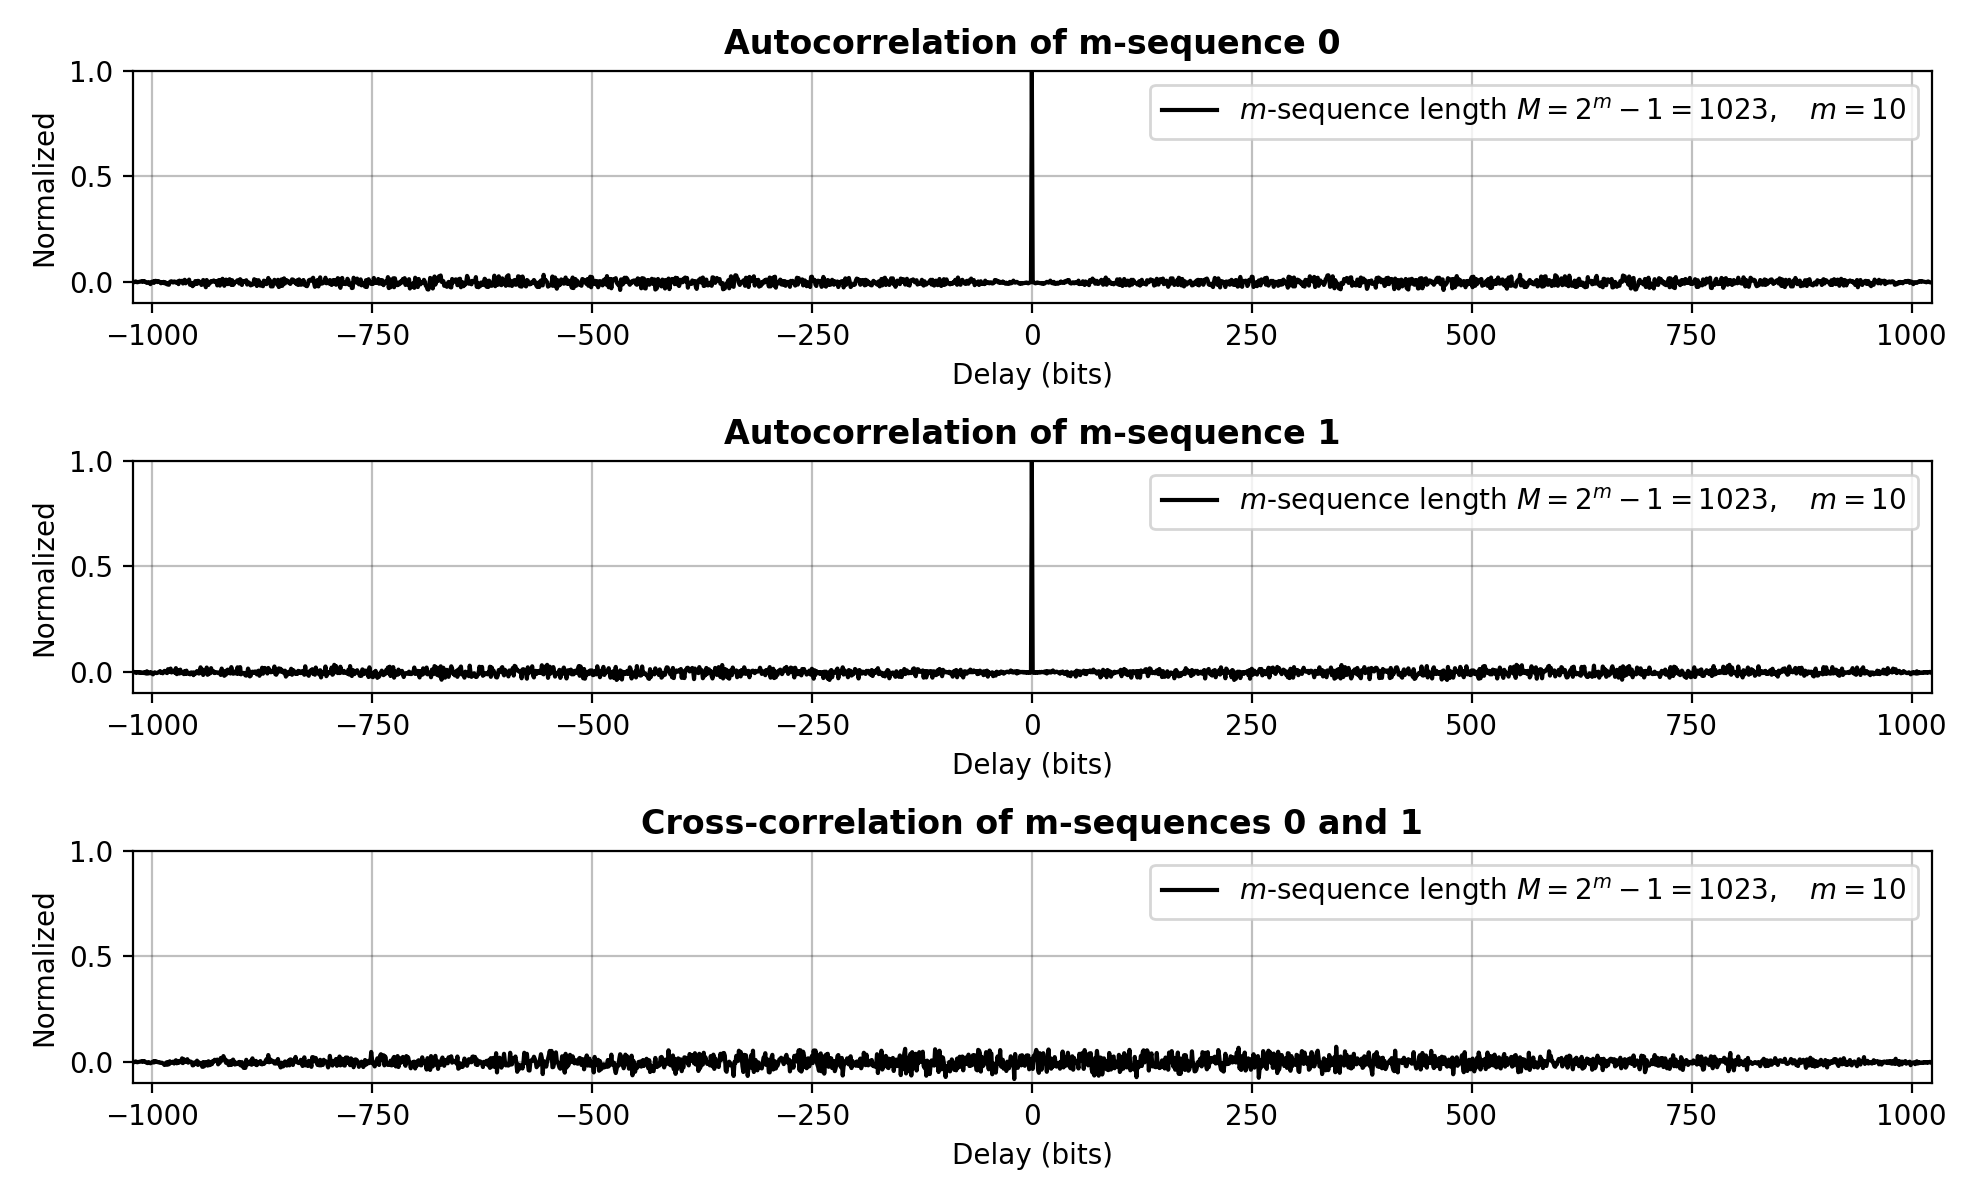

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#######################################################
# Observation vectors by streaming LFSR tapped at 0x1 #
#######################################################

# Tap LFSR or simply use state sequence?...
if enable_tapped_register_obs:

    # Observations formed by tapping a p'th LFSR from a list of options
    X, Y = form_tap_based_obs(LFSRs, p, deg)

#######################################################
# Observation vectors: LFSR state vs. epoch / index n #
#######################################################

# Use state sequence...
else:

    # Observations of 1 period of p'th LFSR in list
    X, Y = register_state_observations(LFSRs[p])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, num_hidden=(deg + 2),
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 12)                120       
_________________________________________________________________
output (Dense)               (None, 10)                120       
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training (save history)
model_history = model.fit(
    
    # Input dataset
    x=X, # state vector "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False)

Train on 1023 samples
Epoch 1/20000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7124 - true_positives: 4221.0000 - true_negatives: 894.0000 - false_positives: 4216.0000 - false_negatives: 899.0000
Epoch 2/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7104 - true_positives: 4152.0000 - true_negatives: 957.0000 - false_positives: 4153.0000 - false_negatives: 968.0000
Epoch 3/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7091 - true_positives: 4107.0000 - true_negatives: 997.0000 - false_positives: 4113.0000 - false_negatives: 1013.0000
Epoch 4/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7081 - true_positives: 4080.0000 - true_negatives: 1026.0000 - false_positives: 4084.0000 - false_negatives: 1040.0000
Epoch 5/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7072 - true_positives: 4057.0000 - true_negatives: 1074.0000 - false_positives: 4036.0000 - 

Epoch 42/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6904 - true_positives: 3436.0000 - true_negatives: 1924.0000 - false_positives: 3186.0000 - false_negatives: 1684.0000
Epoch 43/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6900 - true_positives: 3432.0000 - true_negatives: 1943.0000 - false_positives: 3167.0000 - false_negatives: 1688.0000
Epoch 44/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6897 - true_positives: 3421.0000 - true_negatives: 1958.0000 - false_positives: 3152.0000 - false_negatives: 1699.0000
Epoch 45/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6894 - true_positives: 3400.0000 - true_negatives: 1974.0000 - false_positives: 3136.0000 - false_negatives: 1720.0000
Epoch 46/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6891 - true_positives: 3373.0000 - true_negatives: 1988.0000 - false_positives: 3122.0000 - false_negati

Epoch 83/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6785 - true_positives: 3339.0000 - true_negatives: 2631.0000 - false_positives: 2479.0000 - false_negatives: 1781.0000
Epoch 84/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6783 - true_positives: 3344.0000 - true_negatives: 2640.0000 - false_positives: 2470.0000 - false_negatives: 1776.0000
Epoch 85/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6780 - true_positives: 3349.0000 - true_negatives: 2648.0000 - false_positives: 2462.0000 - false_negatives: 1771.0000
Epoch 86/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6777 - true_positives: 3351.0000 - true_negatives: 2667.0000 - false_positives: 2443.0000 - false_negatives: 1769.0000
Epoch 87/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6775 - true_positives: 3359.0000 - true_negatives: 2673.0000 - false_positives: 2437.0000 - false_negati

Epoch 124/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6678 - true_positives: 3554.0000 - true_negatives: 3163.0000 - false_positives: 1947.0000 - false_negatives: 1566.0000
Epoch 125/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6676 - true_positives: 3561.0000 - true_negatives: 3178.0000 - false_positives: 1932.0000 - false_negatives: 1559.0000
Epoch 126/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6673 - true_positives: 3562.0000 - true_negatives: 3193.0000 - false_positives: 1917.0000 - false_negatives: 1558.0000
Epoch 127/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6671 - true_positives: 3568.0000 - true_negatives: 3206.0000 - false_positives: 1904.0000 - false_negatives: 1552.0000
Epoch 128/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6668 - true_positives: 3571.0000 - true_negatives: 3228.0000 - false_positives: 1882.0000 - false_n

Epoch 165/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6572 - true_positives: 3709.0000 - true_negatives: 3681.0000 - false_positives: 1429.0000 - false_negatives: 1411.0000
Epoch 166/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6569 - true_positives: 3775.0000 - true_negatives: 3644.0000 - false_positives: 1466.0000 - false_negatives: 1345.0000
Epoch 167/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6567 - true_positives: 3716.0000 - true_negatives: 3707.0000 - false_positives: 1403.0000 - false_negatives: 1404.0000
Epoch 168/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6564 - true_positives: 3784.0000 - true_negatives: 3666.0000 - false_positives: 1444.0000 - false_negatives: 1336.0000
Epoch 169/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6562 - true_positives: 3724.0000 - true_negatives: 3729.0000 - false_positives: 1381.0000 - false_n

Epoch 206/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6462 - true_positives: 3879.0000 - true_negatives: 3881.0000 - false_positives: 1229.0000 - false_negatives: 1241.0000
Epoch 207/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6459 - true_positives: 3827.0000 - true_negatives: 3931.0000 - false_positives: 1179.0000 - false_negatives: 1293.0000
Epoch 208/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6457 - true_positives: 3888.0000 - true_negatives: 3888.0000 - false_positives: 1222.0000 - false_negatives: 1232.0000
Epoch 209/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6454 - true_positives: 3841.0000 - true_negatives: 3935.0000 - false_positives: 1175.0000 - false_negatives: 1279.0000
Epoch 210/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6451 - true_positives: 3896.0000 - true_negatives: 3899.0000 - false_positives: 1211.0000 - false_n

Epoch 247/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6347 - true_positives: 3942.0000 - true_negatives: 4028.0000 - false_positives: 1082.0000 - false_negatives: 1178.0000
Epoch 248/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6345 - true_positives: 4008.0000 - true_negatives: 3979.0000 - false_positives: 1131.0000 - false_negatives: 1112.0000
Epoch 249/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6342 - true_positives: 3950.0000 - true_negatives: 4029.0000 - false_positives: 1081.0000 - false_negatives: 1170.0000
Epoch 250/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6339 - true_positives: 4014.0000 - true_negatives: 3979.0000 - false_positives: 1131.0000 - false_negatives: 1106.0000
Epoch 251/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6336 - true_positives: 3951.0000 - true_negatives: 4030.0000 - false_positives: 1080.0000 - false_n

Epoch 288/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6228 - true_positives: 4091.0000 - true_negatives: 4008.0000 - false_positives: 1102.0000 - false_negatives: 1029.0000
Epoch 289/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6225 - true_positives: 4012.0000 - true_negatives: 4073.0000 - false_positives: 1037.0000 - false_negatives: 1108.0000
Epoch 290/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6222 - true_positives: 4095.0000 - true_negatives: 4007.0000 - false_positives: 1103.0000 - false_negatives: 1025.0000
Epoch 291/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6219 - true_positives: 4013.0000 - true_negatives: 4073.0000 - false_positives: 1037.0000 - false_negatives: 1107.0000
Epoch 292/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6217 - true_positives: 4096.0000 - true_negatives: 4008.0000 - false_positives: 1102.0000 - false_n

Epoch 329/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6106 - true_positives: 4046.0000 - true_negatives: 4087.0000 - false_positives: 1023.0000 - false_negatives: 1074.0000
Epoch 330/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6103 - true_positives: 4145.0000 - true_negatives: 3990.0000 - false_positives: 1120.0000 - false_negatives: 975.0000
Epoch 331/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6100 - true_positives: 4045.0000 - true_negatives: 4088.0000 - false_positives: 1022.0000 - false_negatives: 1075.0000
Epoch 332/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6097 - true_positives: 4147.0000 - true_negatives: 3991.0000 - false_positives: 1119.0000 - false_negatives: 973.0000
Epoch 333/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6094 - true_positives: 4050.0000 - true_negatives: 4085.0000 - false_positives: 1025.0000 - false_neg

Epoch 370/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5981 - true_positives: 4167.0000 - true_negatives: 3966.0000 - false_positives: 1144.0000 - false_negatives: 953.0000
Epoch 371/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5978 - true_positives: 4098.0000 - true_negatives: 4058.0000 - false_positives: 1052.0000 - false_negatives: 1022.0000
Epoch 372/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5975 - true_positives: 4173.0000 - true_negatives: 3967.0000 - false_positives: 1143.0000 - false_negatives: 947.0000
Epoch 373/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5972 - true_positives: 4101.0000 - true_negatives: 4062.0000 - false_positives: 1048.0000 - false_negatives: 1019.0000
Epoch 374/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5968 - true_positives: 4175.0000 - true_negatives: 3963.0000 - false_positives: 1147.0000 - false_neg

Epoch 411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5853 - true_positives: 4127.0000 - true_negatives: 4041.0000 - false_positives: 1069.0000 - false_negatives: 993.0000
Epoch 412/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5850 - true_positives: 4183.0000 - true_negatives: 3979.0000 - false_positives: 1131.0000 - false_negatives: 937.0000
Epoch 413/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5847 - true_positives: 4139.0000 - true_negatives: 4027.0000 - false_positives: 1083.0000 - false_negatives: 981.0000
Epoch 414/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5844 - true_positives: 4173.0000 - true_negatives: 3988.0000 - false_positives: 1122.0000 - false_negatives: 947.0000
Epoch 415/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5841 - true_positives: 4153.0000 - true_negatives: 4016.0000 - false_positives: 1094.0000 - false_negat

Epoch 452/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5725 - true_positives: 4175.0000 - true_negatives: 3978.0000 - false_positives: 1132.0000 - false_negatives: 945.0000
Epoch 453/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5722 - true_positives: 4148.0000 - true_negatives: 4012.0000 - false_positives: 1098.0000 - false_negatives: 972.0000
Epoch 454/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5718 - true_positives: 4174.0000 - true_negatives: 3974.0000 - false_positives: 1136.0000 - false_negatives: 946.0000
Epoch 455/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5715 - true_positives: 4149.0000 - true_negatives: 4008.0000 - false_positives: 1102.0000 - false_negatives: 971.0000
Epoch 456/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5712 - true_positives: 4175.0000 - true_negatives: 3974.0000 - false_positives: 1136.0000 - false_negat

Epoch 493/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5596 - true_positives: 4171.0000 - true_negatives: 4010.0000 - false_positives: 1100.0000 - false_negatives: 949.0000
Epoch 494/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5593 - true_positives: 4195.0000 - true_negatives: 3977.0000 - false_positives: 1133.0000 - false_negatives: 925.0000
Epoch 495/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5590 - true_positives: 4171.0000 - true_negatives: 4012.0000 - false_positives: 1098.0000 - false_negatives: 949.0000
Epoch 496/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5586 - true_positives: 4194.0000 - true_negatives: 3978.0000 - false_positives: 1132.0000 - false_negatives: 926.0000
Epoch 497/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5583 - true_positives: 4172.0000 - true_negatives: 4010.0000 - false_positives: 1100.0000 - false_negat

Epoch 534/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5468 - true_positives: 4207.0000 - true_negatives: 3967.0000 - false_positives: 1143.0000 - false_negatives: 913.0000
Epoch 535/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5465 - true_positives: 4194.0000 - true_negatives: 4003.0000 - false_positives: 1107.0000 - false_negatives: 926.0000
Epoch 536/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5462 - true_positives: 4207.0000 - true_negatives: 3969.0000 - false_positives: 1141.0000 - false_negatives: 913.0000
Epoch 537/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5459 - true_positives: 4198.0000 - true_negatives: 4000.0000 - false_positives: 1110.0000 - false_negatives: 922.0000
Epoch 538/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5456 - true_positives: 4207.0000 - true_negatives: 3968.0000 - false_positives: 1142.0000 - false_negat

Epoch 575/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5343 - true_positives: 4219.0000 - true_negatives: 3996.0000 - false_positives: 1114.0000 - false_negatives: 901.0000
Epoch 576/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5340 - true_positives: 4235.0000 - true_negatives: 3975.0000 - false_positives: 1135.0000 - false_negatives: 885.0000
Epoch 577/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5337 - true_positives: 4219.0000 - true_negatives: 3996.0000 - false_positives: 1114.0000 - false_negatives: 901.0000
Epoch 578/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5334 - true_positives: 4234.0000 - true_negatives: 3972.0000 - false_positives: 1138.0000 - false_negatives: 886.0000
Epoch 579/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5331 - true_positives: 4217.0000 - true_negatives: 3999.0000 - false_positives: 1111.0000 - false_negat

Epoch 616/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5220 - true_positives: 4261.0000 - true_negatives: 3974.0000 - false_positives: 1136.0000 - false_negatives: 859.0000
Epoch 617/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5217 - true_positives: 4232.0000 - true_negatives: 4004.0000 - false_positives: 1106.0000 - false_negatives: 888.0000
Epoch 618/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5214 - true_positives: 4260.0000 - true_negatives: 3975.0000 - false_positives: 1135.0000 - false_negatives: 860.0000
Epoch 619/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5211 - true_positives: 4231.0000 - true_negatives: 4008.0000 - false_positives: 1102.0000 - false_negatives: 889.0000
Epoch 620/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5208 - true_positives: 4259.0000 - true_negatives: 3977.0000 - false_positives: 1133.0000 - false_negat

Epoch 657/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5099 - true_positives: 4245.0000 - true_negatives: 4009.0000 - false_positives: 1101.0000 - false_negatives: 875.0000
Epoch 658/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5096 - true_positives: 4270.0000 - true_negatives: 4016.0000 - false_positives: 1094.0000 - false_negatives: 850.0000
Epoch 659/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5094 - true_positives: 4246.0000 - true_negatives: 4011.0000 - false_positives: 1099.0000 - false_negatives: 874.0000
Epoch 660/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5091 - true_positives: 4272.0000 - true_negatives: 4012.0000 - false_positives: 1098.0000 - false_negatives: 848.0000
Epoch 661/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5088 - true_positives: 4246.0000 - true_negatives: 4015.0000 - false_positives: 1095.0000 - false_negat

Epoch 698/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4981 - true_positives: 4274.0000 - true_negatives: 4050.0000 - false_positives: 1060.0000 - false_negatives: 846.0000
Epoch 699/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4979 - true_positives: 4259.0000 - true_negatives: 4056.0000 - false_positives: 1054.0000 - false_negatives: 861.0000
Epoch 700/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4976 - true_positives: 4280.0000 - true_negatives: 4047.0000 - false_positives: 1063.0000 - false_negatives: 840.0000
Epoch 701/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4973 - true_positives: 4259.0000 - true_negatives: 4061.0000 - false_positives: 1049.0000 - false_negatives: 861.0000
Epoch 702/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4970 - true_positives: 4284.0000 - true_negatives: 4047.0000 - false_positives: 1063.0000 - false_negat

Epoch 739/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4866 - true_positives: 4265.0000 - true_negatives: 4076.0000 - false_positives: 1034.0000 - false_negatives: 855.0000
Epoch 740/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4863 - true_positives: 4288.0000 - true_negatives: 4067.0000 - false_positives: 1043.0000 - false_negatives: 832.0000
Epoch 741/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4861 - true_positives: 4264.0000 - true_negatives: 4077.0000 - false_positives: 1033.0000 - false_negatives: 856.0000
Epoch 742/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4858 - true_positives: 4291.0000 - true_negatives: 4066.0000 - false_positives: 1044.0000 - false_negatives: 829.0000
Epoch 743/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4855 - true_positives: 4264.0000 - true_negatives: 4075.0000 - false_positives: 1035.0000 - false_negat

Epoch 780/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4754 - true_positives: 4288.0000 - true_negatives: 4094.0000 - false_positives: 1016.0000 - false_negatives: 832.0000
Epoch 781/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4751 - true_positives: 4277.0000 - true_negatives: 4106.0000 - false_positives: 1004.0000 - false_negatives: 843.0000
Epoch 782/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4748 - true_positives: 4286.0000 - true_negatives: 4098.0000 - false_positives: 1012.0000 - false_negatives: 834.0000
Epoch 783/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4746 - true_positives: 4275.0000 - true_negatives: 4104.0000 - false_positives: 1006.0000 - false_negatives: 845.0000
Epoch 784/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4743 - true_positives: 4284.0000 - true_negatives: 4103.0000 - false_positives: 1007.0000 - false_negat

Epoch 821/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4645 - true_positives: 4279.0000 - true_negatives: 4141.0000 - false_positives: 969.0000 - false_negatives: 841.0000
Epoch 822/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4642 - true_positives: 4299.0000 - true_negatives: 4134.0000 - false_positives: 976.0000 - false_negatives: 821.0000
Epoch 823/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4639 - true_positives: 4280.0000 - true_negatives: 4138.0000 - false_positives: 972.0000 - false_negatives: 840.0000
Epoch 824/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4637 - true_positives: 4299.0000 - true_negatives: 4139.0000 - false_positives: 971.0000 - false_negatives: 821.0000
Epoch 825/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4634 - true_positives: 4282.0000 - true_negatives: 4144.0000 - false_positives: 966.0000 - false_negatives:

Epoch 862/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4539 - true_positives: 4294.0000 - true_negatives: 4176.0000 - false_positives: 934.0000 - false_negatives: 826.0000
Epoch 863/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4536 - true_positives: 4290.0000 - true_negatives: 4179.0000 - false_positives: 931.0000 - false_negatives: 830.0000
Epoch 864/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4533 - true_positives: 4299.0000 - true_negatives: 4176.0000 - false_positives: 934.0000 - false_negatives: 821.0000
Epoch 865/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4531 - true_positives: 4286.0000 - true_negatives: 4179.0000 - false_positives: 931.0000 - false_negatives: 834.0000
Epoch 866/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4528 - true_positives: 4303.0000 - true_negatives: 4175.0000 - false_positives: 935.0000 - false_negatives:

Epoch 903/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4436 - true_positives: 4306.0000 - true_negatives: 4186.0000 - false_positives: 924.0000 - false_negatives: 814.0000
Epoch 904/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4433 - true_positives: 4316.0000 - true_negatives: 4187.0000 - false_positives: 923.0000 - false_negatives: 804.0000
Epoch 905/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4431 - true_positives: 4310.0000 - true_negatives: 4189.0000 - false_positives: 921.0000 - false_negatives: 810.0000
Epoch 906/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4428 - true_positives: 4316.0000 - true_negatives: 4183.0000 - false_positives: 927.0000 - false_negatives: 804.0000
Epoch 907/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4426 - true_positives: 4307.0000 - true_negatives: 4195.0000 - false_positives: 915.0000 - false_negatives:

Epoch 944/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4336 - true_positives: 4329.0000 - true_negatives: 4203.0000 - false_positives: 907.0000 - false_negatives: 791.0000
Epoch 945/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4334 - true_positives: 4318.0000 - true_negatives: 4208.0000 - false_positives: 902.0000 - false_negatives: 802.0000
Epoch 946/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4332 - true_positives: 4328.0000 - true_negatives: 4202.0000 - false_positives: 908.0000 - false_negatives: 792.0000
Epoch 947/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4329 - true_positives: 4317.0000 - true_negatives: 4214.0000 - false_positives: 896.0000 - false_negatives: 803.0000
Epoch 948/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4327 - true_positives: 4330.0000 - true_negatives: 4199.0000 - false_positives: 911.0000 - false_negatives:

Epoch 985/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4240 - true_positives: 4319.0000 - true_negatives: 4236.0000 - false_positives: 874.0000 - false_negatives: 801.0000
Epoch 986/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4238 - true_positives: 4337.0000 - true_negatives: 4210.0000 - false_positives: 900.0000 - false_negatives: 783.0000
Epoch 987/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4236 - true_positives: 4319.0000 - true_negatives: 4236.0000 - false_positives: 874.0000 - false_negatives: 801.0000
Epoch 988/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4233 - true_positives: 4339.0000 - true_negatives: 4213.0000 - false_positives: 897.0000 - false_negatives: 781.0000
Epoch 989/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4231 - true_positives: 4318.0000 - true_negatives: 4238.0000 - false_positives: 872.0000 - false_negatives:

Epoch 1026/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4147 - true_positives: 4356.0000 - true_negatives: 4212.0000 - false_positives: 898.0000 - false_negatives: 764.0000
Epoch 1027/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4145 - true_positives: 4321.0000 - true_negatives: 4265.0000 - false_positives: 845.0000 - false_negatives: 799.0000
Epoch 1028/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4143 - true_positives: 4359.0000 - true_negatives: 4216.0000 - false_positives: 894.0000 - false_negatives: 761.0000
Epoch 1029/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4141 - true_positives: 4319.0000 - true_negatives: 4268.0000 - false_positives: 842.0000 - false_negatives: 801.0000
Epoch 1030/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4138 - true_positives: 4359.0000 - true_negatives: 4217.0000 - false_positives: 893.0000 - false_negat

Epoch 1067/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4058 - true_positives: 4325.0000 - true_negatives: 4281.0000 - false_positives: 829.0000 - false_negatives: 795.0000
Epoch 1068/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4056 - true_positives: 4362.0000 - true_negatives: 4239.0000 - false_positives: 871.0000 - false_negatives: 758.0000
Epoch 1069/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4054 - true_positives: 4328.0000 - true_negatives: 4280.0000 - false_positives: 830.0000 - false_negatives: 792.0000
Epoch 1070/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4051 - true_positives: 4362.0000 - true_negatives: 4241.0000 - false_positives: 869.0000 - false_negatives: 758.0000
Epoch 1071/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4049 - true_positives: 4330.0000 - true_negatives: 4280.0000 - false_positives: 830.0000 - false_negat

Epoch 1108/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3972 - true_positives: 4361.0000 - true_negatives: 4251.0000 - false_positives: 859.0000 - false_negatives: 759.0000
Epoch 1109/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3970 - true_positives: 4320.0000 - true_negatives: 4285.0000 - false_positives: 825.0000 - false_negatives: 800.0000
Epoch 1110/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3968 - true_positives: 4360.0000 - true_negatives: 4253.0000 - false_positives: 857.0000 - false_negatives: 760.0000
Epoch 1111/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3966 - true_positives: 4323.0000 - true_negatives: 4288.0000 - false_positives: 822.0000 - false_negatives: 797.0000
Epoch 1112/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3964 - true_positives: 4360.0000 - true_negatives: 4254.0000 - false_positives: 856.0000 - false_negat

Epoch 1149/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3889 - true_positives: 4320.0000 - true_negatives: 4303.0000 - false_positives: 807.0000 - false_negatives: 800.0000
Epoch 1150/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3887 - true_positives: 4354.0000 - true_negatives: 4264.0000 - false_positives: 846.0000 - false_negatives: 766.0000
Epoch 1151/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3885 - true_positives: 4320.0000 - true_negatives: 4303.0000 - false_positives: 807.0000 - false_negatives: 800.0000
Epoch 1152/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3883 - true_positives: 4354.0000 - true_negatives: 4266.0000 - false_positives: 844.0000 - false_negatives: 766.0000
Epoch 1153/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3881 - true_positives: 4321.0000 - true_negatives: 4302.0000 - false_positives: 808.0000 - false_negat

Epoch 1190/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3810 - true_positives: 4360.0000 - true_negatives: 4288.0000 - false_positives: 822.0000 - false_negatives: 760.0000
Epoch 1191/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3808 - true_positives: 4328.0000 - true_negatives: 4317.0000 - false_positives: 793.0000 - false_negatives: 792.0000
Epoch 1192/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3806 - true_positives: 4360.0000 - true_negatives: 4293.0000 - false_positives: 817.0000 - false_negatives: 760.0000
Epoch 1193/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3804 - true_positives: 4331.0000 - true_negatives: 4318.0000 - false_positives: 792.0000 - false_negatives: 789.0000
Epoch 1194/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3802 - true_positives: 4359.0000 - true_negatives: 4294.0000 - false_positives: 816.0000 - false_negat

Epoch 1231/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3733 - true_positives: 4341.0000 - true_negatives: 4328.0000 - false_positives: 782.0000 - false_negatives: 779.0000
Epoch 1232/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3731 - true_positives: 4362.0000 - true_negatives: 4301.0000 - false_positives: 809.0000 - false_negatives: 758.0000
Epoch 1233/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3729 - true_positives: 4342.0000 - true_negatives: 4333.0000 - false_positives: 777.0000 - false_negatives: 778.0000
Epoch 1234/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3728 - true_positives: 4363.0000 - true_negatives: 4302.0000 - false_positives: 808.0000 - false_negatives: 757.0000
Epoch 1235/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3726 - true_positives: 4342.0000 - true_negatives: 4335.0000 - false_positives: 775.0000 - false_negat

Epoch 1272/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3660 - true_positives: 4367.0000 - true_negatives: 4316.0000 - false_positives: 794.0000 - false_negatives: 753.0000
Epoch 1273/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3658 - true_positives: 4339.0000 - true_negatives: 4343.0000 - false_positives: 767.0000 - false_negatives: 781.0000
Epoch 1274/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3656 - true_positives: 4366.0000 - true_negatives: 4319.0000 - false_positives: 791.0000 - false_negatives: 754.0000
Epoch 1275/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3654 - true_positives: 4341.0000 - true_negatives: 4346.0000 - false_positives: 764.0000 - false_negatives: 779.0000
Epoch 1276/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3653 - true_positives: 4366.0000 - true_negatives: 4320.0000 - false_positives: 790.0000 - false_negat

Epoch 1313/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3589 - true_positives: 4348.0000 - true_negatives: 4353.0000 - false_positives: 757.0000 - false_negatives: 772.0000
Epoch 1314/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3587 - true_positives: 4374.0000 - true_negatives: 4328.0000 - false_positives: 782.0000 - false_negatives: 746.0000
Epoch 1315/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3585 - true_positives: 4350.0000 - true_negatives: 4353.0000 - false_positives: 757.0000 - false_negatives: 770.0000
Epoch 1316/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3584 - true_positives: 4374.0000 - true_negatives: 4328.0000 - false_positives: 782.0000 - false_negatives: 746.0000
Epoch 1317/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3582 - true_positives: 4350.0000 - true_negatives: 4353.0000 - false_positives: 757.0000 - false_negat

Epoch 1354/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3520 - true_positives: 4380.0000 - true_negatives: 4339.0000 - false_positives: 771.0000 - false_negatives: 740.0000
Epoch 1355/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3519 - true_positives: 4349.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negatives: 771.0000
Epoch 1356/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3517 - true_positives: 4380.0000 - true_negatives: 4340.0000 - false_positives: 770.0000 - false_negatives: 740.0000
Epoch 1357/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3515 - true_positives: 4349.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negatives: 771.0000
Epoch 1358/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3514 - true_positives: 4380.0000 - true_negatives: 4343.0000 - false_positives: 767.0000 - false_negat

Epoch 1395/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3455 - true_positives: 4354.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negatives: 766.0000
Epoch 1396/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3453 - true_positives: 4384.0000 - true_negatives: 4342.0000 - false_positives: 768.0000 - false_negatives: 736.0000
Epoch 1397/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3451 - true_positives: 4354.0000 - true_negatives: 4369.0000 - false_positives: 741.0000 - false_negatives: 766.0000
Epoch 1398/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3450 - true_positives: 4384.0000 - true_negatives: 4342.0000 - false_positives: 768.0000 - false_negatives: 736.0000
Epoch 1399/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3448 - true_positives: 4353.0000 - true_negatives: 4371.0000 - false_positives: 739.0000 - false_negat

Epoch 1436/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3391 - true_positives: 4399.0000 - true_negatives: 4342.0000 - false_positives: 768.0000 - false_negatives: 721.0000
Epoch 1437/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3390 - true_positives: 4367.0000 - true_negatives: 4370.0000 - false_positives: 740.0000 - false_negatives: 753.0000
Epoch 1438/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3388 - true_positives: 4399.0000 - true_negatives: 4343.0000 - false_positives: 767.0000 - false_negatives: 721.0000
Epoch 1439/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3387 - true_positives: 4367.0000 - true_negatives: 4369.0000 - false_positives: 741.0000 - false_negatives: 753.0000
Epoch 1440/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3385 - true_positives: 4399.0000 - true_negatives: 4343.0000 - false_positives: 767.0000 - false_negat

Epoch 1477/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3331 - true_positives: 4376.0000 - true_negatives: 4373.0000 - false_positives: 737.0000 - false_negatives: 744.0000
Epoch 1478/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3329 - true_positives: 4406.0000 - true_negatives: 4348.0000 - false_positives: 762.0000 - false_negatives: 714.0000
Epoch 1479/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3328 - true_positives: 4377.0000 - true_negatives: 4374.0000 - false_positives: 736.0000 - false_negatives: 743.0000
Epoch 1480/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3326 - true_positives: 4406.0000 - true_negatives: 4345.0000 - false_positives: 765.0000 - false_negatives: 714.0000
Epoch 1481/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3325 - true_positives: 4376.0000 - true_negatives: 4375.0000 - false_positives: 735.0000 - false_negat

Epoch 1518/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3273 - true_positives: 4412.0000 - true_negatives: 4350.0000 - false_positives: 760.0000 - false_negatives: 708.0000
Epoch 1519/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3271 - true_positives: 4388.0000 - true_negatives: 4381.0000 - false_positives: 729.0000 - false_negatives: 732.0000
Epoch 1520/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3270 - true_positives: 4412.0000 - true_negatives: 4350.0000 - false_positives: 760.0000 - false_negatives: 708.0000
Epoch 1521/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3269 - true_positives: 4389.0000 - true_negatives: 4384.0000 - false_positives: 726.0000 - false_negatives: 731.0000
Epoch 1522/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3267 - true_positives: 4412.0000 - true_negatives: 4351.0000 - false_positives: 759.0000 - false_negat

Epoch 1559/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3217 - true_positives: 4392.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 728.0000
Epoch 1560/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3216 - true_positives: 4412.0000 - true_negatives: 4360.0000 - false_positives: 750.0000 - false_negatives: 708.0000
Epoch 1561/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3215 - true_positives: 4392.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 728.0000
Epoch 1562/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3213 - true_positives: 4411.0000 - true_negatives: 4360.0000 - false_positives: 750.0000 - false_negatives: 709.0000
Epoch 1563/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3212 - true_positives: 4393.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negat

Epoch 1600/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3164 - true_positives: 4412.0000 - true_negatives: 4361.0000 - false_positives: 749.0000 - false_negatives: 708.0000
Epoch 1601/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3163 - true_positives: 4394.0000 - true_negatives: 4382.0000 - false_positives: 728.0000 - false_negatives: 726.0000
Epoch 1602/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3162 - true_positives: 4413.0000 - true_negatives: 4361.0000 - false_positives: 749.0000 - false_negatives: 707.0000
Epoch 1603/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3161 - true_positives: 4394.0000 - true_negatives: 4381.0000 - false_positives: 729.0000 - false_negatives: 726.0000
Epoch 1604/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3159 - true_positives: 4414.0000 - true_negatives: 4359.0000 - false_positives: 751.0000 - false_negat

Epoch 1641/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3114 - true_positives: 4391.0000 - true_negatives: 4385.0000 - false_positives: 725.0000 - false_negatives: 729.0000
Epoch 1642/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3113 - true_positives: 4417.0000 - true_negatives: 4364.0000 - false_positives: 746.0000 - false_negatives: 703.0000
Epoch 1643/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3111 - true_positives: 4392.0000 - true_negatives: 4384.0000 - false_positives: 726.0000 - false_negatives: 728.0000
Epoch 1644/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3110 - true_positives: 4419.0000 - true_negatives: 4363.0000 - false_positives: 747.0000 - false_negatives: 701.0000
Epoch 1645/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3109 - true_positives: 4393.0000 - true_negatives: 4384.0000 - false_positives: 726.0000 - false_negat

Epoch 1682/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3066 - true_positives: 4423.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 697.0000
Epoch 1683/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3065 - true_positives: 4394.0000 - true_negatives: 4383.0000 - false_positives: 727.0000 - false_negatives: 726.0000
Epoch 1684/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3063 - true_positives: 4423.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 697.0000
Epoch 1685/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3062 - true_positives: 4393.0000 - true_negatives: 4383.0000 - false_positives: 727.0000 - false_negatives: 727.0000
Epoch 1686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3061 - true_positives: 4423.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negat

Epoch 1723/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3020 - true_positives: 4400.0000 - true_negatives: 4386.0000 - false_positives: 724.0000 - false_negatives: 720.0000
Epoch 1724/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3019 - true_positives: 4416.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 704.0000
Epoch 1725/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3018 - true_positives: 4400.0000 - true_negatives: 4385.0000 - false_positives: 725.0000 - false_negatives: 720.0000
Epoch 1726/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3017 - true_positives: 4417.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 703.0000
Epoch 1727/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3016 - true_positives: 4401.0000 - true_negatives: 4386.0000 - false_positives: 724.0000 - false_negat

Epoch 1764/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2976 - true_positives: 4414.0000 - true_negatives: 4370.0000 - false_positives: 740.0000 - false_negatives: 706.0000
Epoch 1765/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2975 - true_positives: 4404.0000 - true_negatives: 4387.0000 - false_positives: 723.0000 - false_negatives: 716.0000
Epoch 1766/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2974 - true_positives: 4415.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 705.0000
Epoch 1767/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2973 - true_positives: 4404.0000 - true_negatives: 4389.0000 - false_positives: 721.0000 - false_negatives: 716.0000
Epoch 1768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2972 - true_positives: 4416.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negat

Epoch 1805/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2935 - true_positives: 4407.0000 - true_negatives: 4385.0000 - false_positives: 725.0000 - false_negatives: 713.0000
Epoch 1806/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2934 - true_positives: 4420.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 700.0000
Epoch 1807/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2933 - true_positives: 4405.0000 - true_negatives: 4386.0000 - false_positives: 724.0000 - false_negatives: 715.0000
Epoch 1808/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2932 - true_positives: 4419.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 701.0000
Epoch 1809/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2931 - true_positives: 4405.0000 - true_negatives: 4385.0000 - false_positives: 725.0000 - false_negat

Epoch 1846/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2896 - true_positives: 4423.0000 - true_negatives: 4365.0000 - false_positives: 745.0000 - false_negatives: 697.0000
Epoch 1847/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2895 - true_positives: 4405.0000 - true_negatives: 4383.0000 - false_positives: 727.0000 - false_negatives: 715.0000
Epoch 1848/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2894 - true_positives: 4422.0000 - true_negatives: 4365.0000 - false_positives: 745.0000 - false_negatives: 698.0000
Epoch 1849/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2893 - true_positives: 4406.0000 - true_negatives: 4383.0000 - false_positives: 727.0000 - false_negatives: 714.0000
Epoch 1850/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2892 - true_positives: 4420.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negat

Epoch 1887/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2858 - true_positives: 4407.0000 - true_negatives: 4379.0000 - false_positives: 731.0000 - false_negatives: 713.0000
Epoch 1888/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2857 - true_positives: 4424.0000 - true_negatives: 4364.0000 - false_positives: 746.0000 - false_negatives: 696.0000
Epoch 1889/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2857 - true_positives: 4407.0000 - true_negatives: 4379.0000 - false_positives: 731.0000 - false_negatives: 713.0000
Epoch 1890/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2856 - true_positives: 4424.0000 - true_negatives: 4365.0000 - false_positives: 745.0000 - false_negatives: 696.0000
Epoch 1891/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2855 - true_positives: 4407.0000 - true_negatives: 4379.0000 - false_positives: 731.0000 - false_negat

Epoch 1928/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2823 - true_positives: 4422.0000 - true_negatives: 4363.0000 - false_positives: 747.0000 - false_negatives: 698.0000
Epoch 1929/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2822 - true_positives: 4406.0000 - true_negatives: 4381.0000 - false_positives: 729.0000 - false_negatives: 714.0000
Epoch 1930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2821 - true_positives: 4422.0000 - true_negatives: 4362.0000 - false_positives: 748.0000 - false_negatives: 698.0000
Epoch 1931/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2820 - true_positives: 4405.0000 - true_negatives: 4381.0000 - false_positives: 729.0000 - false_negatives: 715.0000
Epoch 1932/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2819 - true_positives: 4424.0000 - true_negatives: 4362.0000 - false_positives: 748.0000 - false_negat

Epoch 1969/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2789 - true_positives: 4407.0000 - true_negatives: 4380.0000 - false_positives: 730.0000 - false_negatives: 713.0000
Epoch 1970/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2788 - true_positives: 4429.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 691.0000
Epoch 1971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2788 - true_positives: 4407.0000 - true_negatives: 4379.0000 - false_positives: 731.0000 - false_negatives: 713.0000
Epoch 1972/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2787 - true_positives: 4429.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 691.0000
Epoch 1973/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2786 - true_positives: 4407.0000 - true_negatives: 4379.0000 - false_positives: 731.0000 - false_negat

Epoch 2010/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2757 - true_positives: 4433.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 687.0000
Epoch 2011/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2756 - true_positives: 4412.0000 - true_negatives: 4375.0000 - false_positives: 735.0000 - false_negatives: 708.0000
Epoch 2012/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2756 - true_positives: 4433.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 687.0000
Epoch 2013/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2755 - true_positives: 4412.0000 - true_negatives: 4375.0000 - false_positives: 735.0000 - false_negatives: 708.0000
Epoch 2014/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2754 - true_positives: 4433.0000 - true_negatives: 4353.0000 - false_positives: 757.0000 - false_negat

Epoch 2051/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2727 - true_positives: 4415.0000 - true_negatives: 4371.0000 - false_positives: 739.0000 - false_negatives: 705.0000
Epoch 2052/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2726 - true_positives: 4427.0000 - true_negatives: 4353.0000 - false_positives: 757.0000 - false_negatives: 693.0000
Epoch 2053/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2725 - true_positives: 4415.0000 - true_negatives: 4371.0000 - false_positives: 739.0000 - false_negatives: 705.0000
Epoch 2054/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2725 - true_positives: 4426.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 694.0000
Epoch 2055/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2724 - true_positives: 4415.0000 - true_negatives: 4371.0000 - false_positives: 739.0000 - false_negat

Epoch 2092/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2698 - true_positives: 4429.0000 - true_negatives: 4351.0000 - false_positives: 759.0000 - false_negatives: 691.0000
Epoch 2093/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2697 - true_positives: 4417.0000 - true_negatives: 4371.0000 - false_positives: 739.0000 - false_negatives: 703.0000
Epoch 2094/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2696 - true_positives: 4429.0000 - true_negatives: 4352.0000 - false_positives: 758.0000 - false_negatives: 691.0000
Epoch 2095/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2696 - true_positives: 4417.0000 - true_negatives: 4371.0000 - false_positives: 739.0000 - false_negatives: 703.0000
Epoch 2096/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2695 - true_positives: 4429.0000 - true_negatives: 4352.0000 - false_positives: 758.0000 - false_negat

Epoch 2133/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2670 - true_positives: 4416.0000 - true_negatives: 4372.0000 - false_positives: 738.0000 - false_negatives: 704.0000
Epoch 2134/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2669 - true_positives: 4431.0000 - true_negatives: 4353.0000 - false_positives: 757.0000 - false_negatives: 689.0000
Epoch 2135/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2669 - true_positives: 4417.0000 - true_negatives: 4372.0000 - false_positives: 738.0000 - false_negatives: 703.0000
Epoch 2136/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2668 - true_positives: 4431.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 689.0000
Epoch 2137/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2667 - true_positives: 4416.0000 - true_negatives: 4373.0000 - false_positives: 737.0000 - false_negat

Epoch 2174/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2644 - true_positives: 4428.0000 - true_negatives: 4358.0000 - false_positives: 752.0000 - false_negatives: 692.0000
Epoch 2175/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2643 - true_positives: 4409.0000 - true_negatives: 4375.0000 - false_positives: 735.0000 - false_negatives: 711.0000
Epoch 2176/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2643 - true_positives: 4428.0000 - true_negatives: 4360.0000 - false_positives: 750.0000 - false_negatives: 692.0000
Epoch 2177/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2642 - true_positives: 4409.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 711.0000
Epoch 2178/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2641 - true_positives: 4429.0000 - true_negatives: 4360.0000 - false_positives: 750.0000 - false_negat

Epoch 2215/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2619 - true_positives: 4404.0000 - true_negatives: 4384.0000 - false_positives: 726.0000 - false_negatives: 716.0000
Epoch 2216/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2618 - true_positives: 4423.0000 - true_negatives: 4365.0000 - false_positives: 745.0000 - false_negatives: 697.0000
Epoch 2217/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2618 - true_positives: 4403.0000 - true_negatives: 4385.0000 - false_positives: 725.0000 - false_negatives: 717.0000
Epoch 2218/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2617 - true_positives: 4423.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negatives: 697.0000
Epoch 2219/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2616 - true_positives: 4401.0000 - true_negatives: 4385.0000 - false_positives: 725.0000 - false_negat

Epoch 2256/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2595 - true_positives: 4424.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 696.0000
Epoch 2257/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2594 - true_positives: 4398.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negatives: 722.0000
Epoch 2258/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2594 - true_positives: 4423.0000 - true_negatives: 4367.0000 - false_positives: 743.0000 - false_negatives: 697.0000
Epoch 2259/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2593 - true_positives: 4399.0000 - true_negatives: 4402.0000 - false_positives: 708.0000 - false_negatives: 721.0000
Epoch 2260/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2593 - true_positives: 4419.0000 - true_negatives: 4367.0000 - false_positives: 743.0000 - false_negat

Epoch 2297/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2572 - true_positives: 4398.0000 - true_negatives: 4413.0000 - false_positives: 697.0000 - false_negatives: 722.0000
Epoch 2298/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2572 - true_positives: 4419.0000 - true_negatives: 4393.0000 - false_positives: 717.0000 - false_negatives: 701.0000
Epoch 2299/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2571 - true_positives: 4397.0000 - true_negatives: 4413.0000 - false_positives: 697.0000 - false_negatives: 723.0000
Epoch 2300/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2570 - true_positives: 4421.0000 - true_negatives: 4394.0000 - false_positives: 716.0000 - false_negatives: 699.0000
Epoch 2301/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2570 - true_positives: 4396.0000 - true_negatives: 4414.0000 - false_positives: 696.0000 - false_negat

Epoch 2338/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2550 - true_positives: 4424.0000 - true_negatives: 4393.0000 - false_positives: 717.0000 - false_negatives: 696.0000
Epoch 2339/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2550 - true_positives: 4398.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 722.0000
Epoch 2340/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2549 - true_positives: 4424.0000 - true_negatives: 4393.0000 - false_positives: 717.0000 - false_negatives: 696.0000
Epoch 2341/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2549 - true_positives: 4399.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 721.0000
Epoch 2342/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2548 - true_positives: 4423.0000 - true_negatives: 4393.0000 - false_positives: 717.0000 - false_negat

Epoch 2379/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2529 - true_positives: 4409.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 711.0000
Epoch 2380/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2529 - true_positives: 4432.0000 - true_negatives: 4394.0000 - false_positives: 716.0000 - false_negatives: 688.0000
Epoch 2381/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2528 - true_positives: 4409.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 711.0000
Epoch 2382/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2528 - true_positives: 4432.0000 - true_negatives: 4394.0000 - false_positives: 716.0000 - false_negatives: 688.0000
Epoch 2383/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2527 - true_positives: 4409.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negat

Epoch 2420/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2509 - true_positives: 4431.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negatives: 689.0000
Epoch 2421/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2509 - true_positives: 4416.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 704.0000
Epoch 2422/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2508 - true_positives: 4431.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 689.0000
Epoch 2423/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2508 - true_positives: 4416.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negatives: 704.0000
Epoch 2424/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2507 - true_positives: 4431.0000 - true_negatives: 4397.0000 - false_positives: 713.0000 - false_negat

Epoch 2461/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2490 - true_positives: 4417.0000 - true_negatives: 4430.0000 - false_positives: 680.0000 - false_negatives: 703.0000
Epoch 2462/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2490 - true_positives: 4432.0000 - true_negatives: 4402.0000 - false_positives: 708.0000 - false_negatives: 688.0000
Epoch 2463/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2489 - true_positives: 4417.0000 - true_negatives: 4430.0000 - false_positives: 680.0000 - false_negatives: 703.0000
Epoch 2464/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2489 - true_positives: 4432.0000 - true_negatives: 4403.0000 - false_positives: 707.0000 - false_negatives: 688.0000
Epoch 2465/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2488 - true_positives: 4418.0000 - true_negatives: 4428.0000 - false_positives: 682.0000 - false_negat

Epoch 2502/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2471 - true_positives: 4430.0000 - true_negatives: 4419.0000 - false_positives: 691.0000 - false_negatives: 690.0000
Epoch 2503/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2471 - true_positives: 4418.0000 - true_negatives: 4435.0000 - false_positives: 675.0000 - false_negatives: 702.0000
Epoch 2504/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2471 - true_positives: 4431.0000 - true_negatives: 4419.0000 - false_positives: 691.0000 - false_negatives: 689.0000
Epoch 2505/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2470 - true_positives: 4419.0000 - true_negatives: 4437.0000 - false_positives: 673.0000 - false_negatives: 701.0000
Epoch 2506/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2470 - true_positives: 4431.0000 - true_negatives: 4417.0000 - false_positives: 693.0000 - false_negat

Epoch 2543/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2454 - true_positives: 4415.0000 - true_negatives: 4448.0000 - false_positives: 662.0000 - false_negatives: 705.0000
Epoch 2544/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2453 - true_positives: 4431.0000 - true_negatives: 4415.0000 - false_positives: 695.0000 - false_negatives: 689.0000
Epoch 2545/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2453 - true_positives: 4415.0000 - true_negatives: 4450.0000 - false_positives: 660.0000 - false_negatives: 705.0000
Epoch 2546/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2452 - true_positives: 4430.0000 - true_negatives: 4418.0000 - false_positives: 692.0000 - false_negatives: 690.0000
Epoch 2547/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2452 - true_positives: 4416.0000 - true_negatives: 4450.0000 - false_positives: 660.0000 - false_negat

Epoch 2584/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2436 - true_positives: 4429.0000 - true_negatives: 4429.0000 - false_positives: 681.0000 - false_negatives: 691.0000
Epoch 2585/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2436 - true_positives: 4423.0000 - true_negatives: 4451.0000 - false_positives: 659.0000 - false_negatives: 697.0000
Epoch 2586/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2436 - true_positives: 4429.0000 - true_negatives: 4430.0000 - false_positives: 680.0000 - false_negatives: 691.0000
Epoch 2587/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2435 - true_positives: 4423.0000 - true_negatives: 4451.0000 - false_positives: 659.0000 - false_negatives: 697.0000
Epoch 2588/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2435 - true_positives: 4429.0000 - true_negatives: 4430.0000 - false_positives: 680.0000 - false_negat

Epoch 2625/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2420 - true_positives: 4422.0000 - true_negatives: 4455.0000 - false_positives: 655.0000 - false_negatives: 698.0000
Epoch 2626/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2420 - true_positives: 4433.0000 - true_negatives: 4435.0000 - false_positives: 675.0000 - false_negatives: 687.0000
Epoch 2627/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2419 - true_positives: 4423.0000 - true_negatives: 4456.0000 - false_positives: 654.0000 - false_negatives: 697.0000
Epoch 2628/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2419 - true_positives: 4433.0000 - true_negatives: 4437.0000 - false_positives: 673.0000 - false_negatives: 687.0000
Epoch 2629/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2418 - true_positives: 4423.0000 - true_negatives: 4456.0000 - false_positives: 654.0000 - false_negat

Epoch 2666/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2404 - true_positives: 4436.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negatives: 684.0000
Epoch 2667/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2404 - true_positives: 4423.0000 - true_negatives: 4457.0000 - false_positives: 653.0000 - false_negatives: 697.0000
Epoch 2668/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2403 - true_positives: 4435.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negatives: 685.0000
Epoch 2669/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2403 - true_positives: 4423.0000 - true_negatives: 4457.0000 - false_positives: 653.0000 - false_negatives: 697.0000
Epoch 2670/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2402 - true_positives: 4435.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negat

Epoch 2707/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2389 - true_positives: 4426.0000 - true_negatives: 4458.0000 - false_positives: 652.0000 - false_negatives: 694.0000
Epoch 2708/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2388 - true_positives: 4438.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negatives: 682.0000
Epoch 2709/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2388 - true_positives: 4426.0000 - true_negatives: 4458.0000 - false_positives: 652.0000 - false_negatives: 694.0000
Epoch 2710/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2387 - true_positives: 4438.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negatives: 682.0000
Epoch 2711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2387 - true_positives: 4427.0000 - true_negatives: 4459.0000 - false_positives: 651.0000 - false_negat

Epoch 2748/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2374 - true_positives: 4436.0000 - true_negatives: 4453.0000 - false_positives: 657.0000 - false_negatives: 684.0000
Epoch 2749/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2373 - true_positives: 4424.0000 - true_negatives: 4476.0000 - false_positives: 634.0000 - false_negatives: 696.0000
Epoch 2750/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2373 - true_positives: 4436.0000 - true_negatives: 4453.0000 - false_positives: 657.0000 - false_negatives: 684.0000
Epoch 2751/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2373 - true_positives: 4423.0000 - true_negatives: 4478.0000 - false_positives: 632.0000 - false_negatives: 697.0000
Epoch 2752/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2372 - true_positives: 4436.0000 - true_negatives: 4453.0000 - false_positives: 657.0000 - false_negat

Epoch 2789/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2359 - true_positives: 4415.0000 - true_negatives: 4497.0000 - false_positives: 613.0000 - false_negatives: 705.0000
Epoch 2790/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2359 - true_positives: 4423.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 697.0000
Epoch 2791/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2359 - true_positives: 4415.0000 - true_negatives: 4498.0000 - false_positives: 612.0000 - false_negatives: 705.0000
Epoch 2792/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2358 - true_positives: 4423.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 697.0000
Epoch 2793/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2358 - true_positives: 4412.0000 - true_negatives: 4498.0000 - false_positives: 612.0000 - false_negat

Epoch 2830/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2345 - true_positives: 4421.0000 - true_negatives: 4491.0000 - false_positives: 619.0000 - false_negatives: 699.0000
Epoch 2831/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2345 - true_positives: 4409.0000 - true_negatives: 4513.0000 - false_positives: 597.0000 - false_negatives: 711.0000
Epoch 2832/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2345 - true_positives: 4420.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negatives: 700.0000
Epoch 2833/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2344 - true_positives: 4410.0000 - true_negatives: 4513.0000 - false_positives: 597.0000 - false_negatives: 710.0000
Epoch 2834/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2344 - true_positives: 4422.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negat

Epoch 2871/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2332 - true_positives: 4408.0000 - true_negatives: 4529.0000 - false_positives: 581.0000 - false_negatives: 712.0000
Epoch 2872/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2332 - true_positives: 4431.0000 - true_negatives: 4509.0000 - false_positives: 601.0000 - false_negatives: 689.0000
Epoch 2873/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2331 - true_positives: 4409.0000 - true_negatives: 4531.0000 - false_positives: 579.0000 - false_negatives: 711.0000
Epoch 2874/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2331 - true_positives: 4431.0000 - true_negatives: 4508.0000 - false_positives: 602.0000 - false_negatives: 689.0000
Epoch 2875/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2331 - true_positives: 4409.0000 - true_negatives: 4533.0000 - false_positives: 577.0000 - false_negat

Epoch 2912/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2319 - true_positives: 4433.0000 - true_negatives: 4520.0000 - false_positives: 590.0000 - false_negatives: 687.0000
Epoch 2913/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2319 - true_positives: 4417.0000 - true_negatives: 4535.0000 - false_positives: 575.0000 - false_negatives: 703.0000
Epoch 2914/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2319 - true_positives: 4433.0000 - true_negatives: 4521.0000 - false_positives: 589.0000 - false_negatives: 687.0000
Epoch 2915/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2318 - true_positives: 4418.0000 - true_negatives: 4535.0000 - false_positives: 575.0000 - false_negatives: 702.0000
Epoch 2916/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2318 - true_positives: 4433.0000 - true_negatives: 4521.0000 - false_positives: 589.0000 - false_negat

Epoch 2953/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2307 - true_positives: 4420.0000 - true_negatives: 4553.0000 - false_positives: 557.0000 - false_negatives: 700.0000
Epoch 2954/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2306 - true_positives: 4431.0000 - true_negatives: 4524.0000 - false_positives: 586.0000 - false_negatives: 689.0000
Epoch 2955/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2306 - true_positives: 4420.0000 - true_negatives: 4554.0000 - false_positives: 556.0000 - false_negatives: 700.0000
Epoch 2956/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2306 - true_positives: 4431.0000 - true_negatives: 4524.0000 - false_positives: 586.0000 - false_negatives: 689.0000
Epoch 2957/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2305 - true_positives: 4419.0000 - true_negatives: 4554.0000 - false_positives: 556.0000 - false_negat

Epoch 2994/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2294 - true_positives: 4429.0000 - true_negatives: 4545.0000 - false_positives: 565.0000 - false_negatives: 691.0000
Epoch 2995/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2294 - true_positives: 4423.0000 - true_negatives: 4558.0000 - false_positives: 552.0000 - false_negatives: 697.0000
Epoch 2996/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2294 - true_positives: 4429.0000 - true_negatives: 4545.0000 - false_positives: 565.0000 - false_negatives: 691.0000
Epoch 2997/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2294 - true_positives: 4423.0000 - true_negatives: 4558.0000 - false_positives: 552.0000 - false_negatives: 697.0000
Epoch 2998/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2293 - true_positives: 4429.0000 - true_negatives: 4545.0000 - false_positives: 565.0000 - false_negat

Epoch 3035/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2283 - true_positives: 4423.0000 - true_negatives: 4558.0000 - false_positives: 552.0000 - false_negatives: 697.0000
Epoch 3036/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2282 - true_positives: 4427.0000 - true_negatives: 4551.0000 - false_positives: 559.0000 - false_negatives: 693.0000
Epoch 3037/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2282 - true_positives: 4423.0000 - true_negatives: 4558.0000 - false_positives: 552.0000 - false_negatives: 697.0000
Epoch 3038/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2282 - true_positives: 4427.0000 - true_negatives: 4551.0000 - false_positives: 559.0000 - false_negatives: 693.0000
Epoch 3039/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2282 - true_positives: 4423.0000 - true_negatives: 4559.0000 - false_positives: 551.0000 - false_negat

Epoch 3076/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2271 - true_positives: 4428.0000 - true_negatives: 4555.0000 - false_positives: 555.0000 - false_negatives: 692.0000
Epoch 3077/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2271 - true_positives: 4421.0000 - true_negatives: 4565.0000 - false_positives: 545.0000 - false_negatives: 699.0000
Epoch 3078/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2271 - true_positives: 4427.0000 - true_negatives: 4555.0000 - false_positives: 555.0000 - false_negatives: 693.0000
Epoch 3079/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2270 - true_positives: 4421.0000 - true_negatives: 4566.0000 - false_positives: 544.0000 - false_negatives: 699.0000
Epoch 3080/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2270 - true_positives: 4427.0000 - true_negatives: 4555.0000 - false_positives: 555.0000 - false_negat

Epoch 3117/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2260 - true_positives: 4421.0000 - true_negatives: 4570.0000 - false_positives: 540.0000 - false_negatives: 699.0000
Epoch 3118/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2260 - true_positives: 4433.0000 - true_negatives: 4561.0000 - false_positives: 549.0000 - false_negatives: 687.0000
Epoch 3119/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2259 - true_positives: 4420.0000 - true_negatives: 4571.0000 - false_positives: 539.0000 - false_negatives: 700.0000
Epoch 3120/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2259 - true_positives: 4434.0000 - true_negatives: 4562.0000 - false_positives: 548.0000 - false_negatives: 686.0000
Epoch 3121/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2259 - true_positives: 4420.0000 - true_negatives: 4572.0000 - false_positives: 538.0000 - false_negat

Epoch 3158/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2249 - true_positives: 4436.0000 - true_negatives: 4564.0000 - false_positives: 546.0000 - false_negatives: 684.0000
Epoch 3159/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2249 - true_positives: 4426.0000 - true_negatives: 4577.0000 - false_positives: 533.0000 - false_negatives: 694.0000
Epoch 3160/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2248 - true_positives: 4435.0000 - true_negatives: 4565.0000 - false_positives: 545.0000 - false_negatives: 685.0000
Epoch 3161/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2248 - true_positives: 4426.0000 - true_negatives: 4577.0000 - false_positives: 533.0000 - false_negatives: 694.0000
Epoch 3162/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2248 - true_positives: 4435.0000 - true_negatives: 4565.0000 - false_positives: 545.0000 - false_negat

Epoch 3199/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2238 - true_positives: 4430.0000 - true_negatives: 4579.0000 - false_positives: 531.0000 - false_negatives: 690.0000
Epoch 3200/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2238 - true_positives: 4444.0000 - true_negatives: 4570.0000 - false_positives: 540.0000 - false_negatives: 676.0000
Epoch 3201/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2238 - true_positives: 4430.0000 - true_negatives: 4578.0000 - false_positives: 532.0000 - false_negatives: 690.0000
Epoch 3202/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2237 - true_positives: 4444.0000 - true_negatives: 4569.0000 - false_positives: 541.0000 - false_negatives: 676.0000
Epoch 3203/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2237 - true_positives: 4430.0000 - true_negatives: 4578.0000 - false_positives: 532.0000 - false_negat

Epoch 3240/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2228 - true_positives: 4450.0000 - true_negatives: 4567.0000 - false_positives: 543.0000 - false_negatives: 670.0000
Epoch 3241/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2228 - true_positives: 4438.0000 - true_negatives: 4581.0000 - false_positives: 529.0000 - false_negatives: 682.0000
Epoch 3242/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2227 - true_positives: 4450.0000 - true_negatives: 4566.0000 - false_positives: 544.0000 - false_negatives: 670.0000
Epoch 3243/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2227 - true_positives: 4439.0000 - true_negatives: 4581.0000 - false_positives: 529.0000 - false_negatives: 681.0000
Epoch 3244/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2227 - true_positives: 4451.0000 - true_negatives: 4567.0000 - false_positives: 543.0000 - false_negat

Epoch 3281/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2218 - true_positives: 4437.0000 - true_negatives: 4595.0000 - false_positives: 515.0000 - false_negatives: 683.0000
Epoch 3282/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2217 - true_positives: 4455.0000 - true_negatives: 4570.0000 - false_positives: 540.0000 - false_negatives: 665.0000
Epoch 3283/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2217 - true_positives: 4435.0000 - true_negatives: 4596.0000 - false_positives: 514.0000 - false_negatives: 685.0000
Epoch 3284/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2217 - true_positives: 4455.0000 - true_negatives: 4570.0000 - false_positives: 540.0000 - false_negatives: 665.0000
Epoch 3285/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2217 - true_positives: 4436.0000 - true_negatives: 4596.0000 - false_positives: 514.0000 - false_negat

Epoch 3322/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2208 - true_positives: 4452.0000 - true_negatives: 4582.0000 - false_positives: 528.0000 - false_negatives: 668.0000
Epoch 3323/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2207 - true_positives: 4446.0000 - true_negatives: 4598.0000 - false_positives: 512.0000 - false_negatives: 674.0000
Epoch 3324/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2207 - true_positives: 4452.0000 - true_negatives: 4583.0000 - false_positives: 527.0000 - false_negatives: 668.0000
Epoch 3325/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2207 - true_positives: 4445.0000 - true_negatives: 4599.0000 - false_positives: 511.0000 - false_negatives: 675.0000
Epoch 3326/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2207 - true_positives: 4452.0000 - true_negatives: 4585.0000 - false_positives: 525.0000 - false_negat

Epoch 3363/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2198 - true_positives: 4447.0000 - true_negatives: 4601.0000 - false_positives: 509.0000 - false_negatives: 673.0000
Epoch 3364/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2198 - true_positives: 4458.0000 - true_negatives: 4590.0000 - false_positives: 520.0000 - false_negatives: 662.0000
Epoch 3365/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2197 - true_positives: 4447.0000 - true_negatives: 4601.0000 - false_positives: 509.0000 - false_negatives: 673.0000
Epoch 3366/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2197 - true_positives: 4458.0000 - true_negatives: 4591.0000 - false_positives: 519.0000 - false_negatives: 662.0000
Epoch 3367/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2197 - true_positives: 4447.0000 - true_negatives: 4601.0000 - false_positives: 509.0000 - false_negat

Epoch 3404/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2188 - true_positives: 4468.0000 - true_negatives: 4595.0000 - false_positives: 515.0000 - false_negatives: 652.0000
Epoch 3405/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2188 - true_positives: 4453.0000 - true_negatives: 4603.0000 - false_positives: 507.0000 - false_negatives: 667.0000
Epoch 3406/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2188 - true_positives: 4468.0000 - true_negatives: 4594.0000 - false_positives: 516.0000 - false_negatives: 652.0000
Epoch 3407/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2188 - true_positives: 4453.0000 - true_negatives: 4605.0000 - false_positives: 505.0000 - false_negatives: 667.0000
Epoch 3408/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2187 - true_positives: 4468.0000 - true_negatives: 4593.0000 - false_positives: 517.0000 - false_negat

Epoch 3445/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2179 - true_positives: 4461.0000 - true_negatives: 4606.0000 - false_positives: 504.0000 - false_negatives: 659.0000
Epoch 3446/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2179 - true_positives: 4479.0000 - true_negatives: 4592.0000 - false_positives: 518.0000 - false_negatives: 641.0000
Epoch 3447/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2178 - true_positives: 4461.0000 - true_negatives: 4606.0000 - false_positives: 504.0000 - false_negatives: 659.0000
Epoch 3448/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2178 - true_positives: 4479.0000 - true_negatives: 4592.0000 - false_positives: 518.0000 - false_negatives: 641.0000
Epoch 3449/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2178 - true_positives: 4461.0000 - true_negatives: 4606.0000 - false_positives: 504.0000 - false_negat

Epoch 3486/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2170 - true_positives: 4485.0000 - true_negatives: 4599.0000 - false_positives: 511.0000 - false_negatives: 635.0000
Epoch 3487/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2169 - true_positives: 4468.0000 - true_negatives: 4608.0000 - false_positives: 502.0000 - false_negatives: 652.0000
Epoch 3488/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2169 - true_positives: 4484.0000 - true_negatives: 4599.0000 - false_positives: 511.0000 - false_negatives: 636.0000
Epoch 3489/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2169 - true_positives: 4468.0000 - true_negatives: 4610.0000 - false_positives: 500.0000 - false_negatives: 652.0000
Epoch 3490/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2169 - true_positives: 4486.0000 - true_negatives: 4598.0000 - false_positives: 512.0000 - false_negat

Epoch 3527/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2161 - true_positives: 4472.0000 - true_negatives: 4618.0000 - false_positives: 492.0000 - false_negatives: 648.0000
Epoch 3528/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2161 - true_positives: 4489.0000 - true_negatives: 4602.0000 - false_positives: 508.0000 - false_negatives: 631.0000
Epoch 3529/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2160 - true_positives: 4472.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 648.0000
Epoch 3530/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2160 - true_positives: 4489.0000 - true_negatives: 4602.0000 - false_positives: 508.0000 - false_negatives: 631.0000
Epoch 3531/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2160 - true_positives: 4472.0000 - true_negatives: 4621.0000 - false_positives: 489.0000 - false_negat

Epoch 3568/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2152 - true_positives: 4496.0000 - true_negatives: 4608.0000 - false_positives: 502.0000 - false_negatives: 624.0000
Epoch 3569/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2152 - true_positives: 4479.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 641.0000
Epoch 3570/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2152 - true_positives: 4497.0000 - true_negatives: 4608.0000 - false_positives: 502.0000 - false_negatives: 623.0000
Epoch 3571/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2151 - true_positives: 4479.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 641.0000
Epoch 3572/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2151 - true_positives: 4497.0000 - true_negatives: 4608.0000 - false_positives: 502.0000 - false_negat

Epoch 3609/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2143 - true_positives: 4486.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 634.0000
Epoch 3610/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2143 - true_positives: 4508.0000 - true_negatives: 4610.0000 - false_positives: 500.0000 - false_negatives: 612.0000
Epoch 3611/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2143 - true_positives: 4487.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 633.0000
Epoch 3612/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2143 - true_positives: 4509.0000 - true_negatives: 4609.0000 - false_positives: 501.0000 - false_negatives: 611.0000
Epoch 3613/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2143 - true_positives: 4487.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negat

Epoch 3650/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2135 - true_positives: 4512.0000 - true_negatives: 4614.0000 - false_positives: 496.0000 - false_negatives: 608.0000
Epoch 3651/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2135 - true_positives: 4506.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 614.0000
Epoch 3652/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2135 - true_positives: 4512.0000 - true_negatives: 4614.0000 - false_positives: 496.0000 - false_negatives: 608.0000
Epoch 3653/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2134 - true_positives: 4506.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 614.0000
Epoch 3654/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2134 - true_positives: 4512.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negat

Epoch 3691/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2127 - true_positives: 4507.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 613.0000
Epoch 3692/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2127 - true_positives: 4518.0000 - true_negatives: 4622.0000 - false_positives: 488.0000 - false_negatives: 602.0000
Epoch 3693/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2126 - true_positives: 4507.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 613.0000
Epoch 3694/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2126 - true_positives: 4518.0000 - true_negatives: 4622.0000 - false_positives: 488.0000 - false_negatives: 602.0000
Epoch 3695/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2126 - true_positives: 4507.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negat

Epoch 3732/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2119 - true_positives: 4521.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 599.0000
Epoch 3733/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2118 - true_positives: 4516.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 604.0000
Epoch 3734/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2118 - true_positives: 4521.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 599.0000
Epoch 3735/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2118 - true_positives: 4516.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negatives: 604.0000
Epoch 3736/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2118 - true_positives: 4521.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negat

Epoch 3773/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2111 - true_positives: 4515.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 605.0000
Epoch 3774/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2111 - true_positives: 4524.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 596.0000
Epoch 3775/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2110 - true_positives: 4516.0000 - true_negatives: 4629.0000 - false_positives: 481.0000 - false_negatives: 604.0000
Epoch 3776/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2110 - true_positives: 4524.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 596.0000
Epoch 3777/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2110 - true_positives: 4515.0000 - true_negatives: 4629.0000 - false_positives: 481.0000 - false_negat

Epoch 3814/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2103 - true_positives: 4525.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 595.0000
Epoch 3815/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2103 - true_positives: 4515.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 605.0000
Epoch 3816/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2103 - true_positives: 4525.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negatives: 595.0000
Epoch 3817/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2102 - true_positives: 4515.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 605.0000
Epoch 3818/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2102 - true_positives: 4525.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negat

Epoch 3855/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2095 - true_positives: 4517.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 603.0000
Epoch 3856/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2095 - true_positives: 4524.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 596.0000
Epoch 3857/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2095 - true_positives: 4517.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 603.0000
Epoch 3858/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2095 - true_positives: 4524.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 596.0000
Epoch 3859/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2095 - true_positives: 4517.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negat

Epoch 3896/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2088 - true_positives: 4527.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 593.0000
Epoch 3897/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2088 - true_positives: 4518.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 602.0000
Epoch 3898/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2088 - true_positives: 4527.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 593.0000
Epoch 3899/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2087 - true_positives: 4518.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 602.0000
Epoch 3900/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2087 - true_positives: 4527.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negat

Epoch 3937/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2081 - true_positives: 4526.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 594.0000
Epoch 3938/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2081 - true_positives: 4534.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 586.0000
Epoch 3939/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2080 - true_positives: 4527.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 593.0000
Epoch 3940/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2080 - true_positives: 4534.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 586.0000
Epoch 3941/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2080 - true_positives: 4527.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negat

Epoch 3978/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2074 - true_positives: 4532.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 588.0000
Epoch 3979/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2073 - true_positives: 4530.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 590.0000
Epoch 3980/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2073 - true_positives: 4532.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 588.0000
Epoch 3981/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2073 - true_positives: 4530.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 590.0000
Epoch 3982/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2073 - true_positives: 4532.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negat

Epoch 4019/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2067 - true_positives: 4530.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negatives: 590.0000
Epoch 4020/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2066 - true_positives: 4533.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 587.0000
Epoch 4021/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2066 - true_positives: 4530.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negatives: 590.0000
Epoch 4022/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2066 - true_positives: 4533.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 587.0000
Epoch 4023/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2066 - true_positives: 4530.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negat

Epoch 4060/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2060 - true_positives: 4538.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 582.0000
Epoch 4061/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2060 - true_positives: 4530.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negatives: 590.0000
Epoch 4062/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2059 - true_positives: 4538.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 582.0000
Epoch 4063/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2059 - true_positives: 4530.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negatives: 590.0000
Epoch 4064/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2059 - true_positives: 4539.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negat

Epoch 4101/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2053 - true_positives: 4534.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 586.0000
Epoch 4102/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2053 - true_positives: 4541.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 579.0000
Epoch 4103/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2053 - true_positives: 4534.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 586.0000
Epoch 4104/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2052 - true_positives: 4542.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 578.0000
Epoch 4105/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2052 - true_positives: 4534.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negat

Epoch 4142/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2046 - true_positives: 4547.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 573.0000
Epoch 4143/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2046 - true_positives: 4535.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 585.0000
Epoch 4144/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2046 - true_positives: 4548.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 572.0000
Epoch 4145/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2046 - true_positives: 4534.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 586.0000
Epoch 4146/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2046 - true_positives: 4549.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negat

Epoch 4183/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2040 - true_positives: 4542.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 578.0000
Epoch 4184/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2040 - true_positives: 4552.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 568.0000
Epoch 4185/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2040 - true_positives: 4542.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 578.0000
Epoch 4186/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2039 - true_positives: 4553.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 567.0000
Epoch 4187/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2039 - true_positives: 4541.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negat

Epoch 4224/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2033 - true_positives: 4562.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 558.0000
Epoch 4225/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2033 - true_positives: 4545.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 575.0000
Epoch 4226/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2033 - true_positives: 4562.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 558.0000
Epoch 4227/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2033 - true_positives: 4545.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 575.0000
Epoch 4228/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2033 - true_positives: 4564.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negat

Epoch 4265/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2027 - true_positives: 4553.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 567.0000
Epoch 4266/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2027 - true_positives: 4563.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 557.0000
Epoch 4267/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2027 - true_positives: 4553.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 567.0000
Epoch 4268/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2027 - true_positives: 4563.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 557.0000
Epoch 4269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2026 - true_positives: 4553.0000 - true_negatives: 4650.0000 - false_positives: 460.0000 - false_negat

Epoch 4306/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2021 - true_positives: 4574.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 546.0000
Epoch 4307/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2021 - true_positives: 4560.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 560.0000
Epoch 4308/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2020 - true_positives: 4574.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 546.0000
Epoch 4309/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2020 - true_positives: 4560.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 560.0000
Epoch 4310/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2020 - true_positives: 4575.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negat

Epoch 4347/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2015 - true_positives: 4565.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 555.0000
Epoch 4348/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2014 - true_positives: 4576.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 544.0000
Epoch 4349/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2014 - true_positives: 4566.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 554.0000
Epoch 4350/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2014 - true_positives: 4576.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 544.0000
Epoch 4351/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2014 - true_positives: 4566.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negat

Epoch 4388/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2008 - true_positives: 4578.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 542.0000
Epoch 4389/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2008 - true_positives: 4572.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 548.0000
Epoch 4390/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2008 - true_positives: 4578.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 542.0000
Epoch 4391/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2008 - true_positives: 4572.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 548.0000
Epoch 4392/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2008 - true_positives: 4578.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negat

Epoch 4429/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2002 - true_positives: 4575.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 545.0000
Epoch 4430/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2002 - true_positives: 4582.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 538.0000
Epoch 4431/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2002 - true_positives: 4575.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 545.0000
Epoch 4432/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2002 - true_positives: 4582.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 538.0000
Epoch 4433/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2002 - true_positives: 4575.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negat

Epoch 4470/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1996 - true_positives: 4588.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 532.0000
Epoch 4471/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1996 - true_positives: 4572.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 548.0000
Epoch 4472/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1996 - true_positives: 4589.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 531.0000
Epoch 4473/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1996 - true_positives: 4573.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 547.0000
Epoch 4474/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1996 - true_positives: 4589.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negat

Epoch 4511/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1990 - true_positives: 4574.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 546.0000
Epoch 4512/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1990 - true_positives: 4591.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 529.0000
Epoch 4513/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1990 - true_positives: 4574.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 546.0000
Epoch 4514/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1990 - true_positives: 4591.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 529.0000
Epoch 4515/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1990 - true_positives: 4574.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negat

Epoch 4552/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1985 - true_positives: 4595.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 525.0000
Epoch 4553/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1984 - true_positives: 4585.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 535.0000
Epoch 4554/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1984 - true_positives: 4595.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 525.0000
Epoch 4555/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1984 - true_positives: 4584.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 536.0000
Epoch 4556/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1984 - true_positives: 4597.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negat

Epoch 4593/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1979 - true_positives: 4585.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negatives: 535.0000
Epoch 4594/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1979 - true_positives: 4603.0000 - true_negatives: 4629.0000 - false_positives: 481.0000 - false_negatives: 517.0000
Epoch 4595/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1978 - true_positives: 4585.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negatives: 535.0000
Epoch 4596/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1978 - true_positives: 4603.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 517.0000
Epoch 4597/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1978 - true_positives: 4585.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negat

Epoch 4634/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1973 - true_positives: 4608.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 512.0000
Epoch 4635/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1973 - true_positives: 4594.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 526.0000
Epoch 4636/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1973 - true_positives: 4608.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 512.0000
Epoch 4637/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1973 - true_positives: 4594.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 526.0000
Epoch 4638/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1972 - true_positives: 4609.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negat

Epoch 4675/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1967 - true_positives: 4601.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 519.0000
Epoch 4676/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1967 - true_positives: 4614.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 506.0000
Epoch 4677/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1967 - true_positives: 4602.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 518.0000
Epoch 4678/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1967 - true_positives: 4614.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 506.0000
Epoch 4679/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1967 - true_positives: 4602.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negat

Epoch 4716/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1962 - true_positives: 4618.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 502.0000
Epoch 4717/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1962 - true_positives: 4607.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 513.0000
Epoch 4718/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1961 - true_positives: 4618.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 502.0000
Epoch 4719/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1961 - true_positives: 4607.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 513.0000
Epoch 4720/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1961 - true_positives: 4618.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negat

Epoch 4757/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1956 - true_positives: 4611.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 509.0000
Epoch 4758/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1956 - true_positives: 4619.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 501.0000
Epoch 4759/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1956 - true_positives: 4611.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 509.0000
Epoch 4760/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1956 - true_positives: 4619.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 501.0000
Epoch 4761/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1956 - true_positives: 4612.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negat

Epoch 4798/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1951 - true_positives: 4626.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 494.0000
Epoch 4799/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1950 - true_positives: 4613.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 507.0000
Epoch 4800/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1950 - true_positives: 4626.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 494.0000
Epoch 4801/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1950 - true_positives: 4613.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 507.0000
Epoch 4802/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1950 - true_positives: 4628.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negat

Epoch 4839/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1945 - true_positives: 4615.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 505.0000
Epoch 4840/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1945 - true_positives: 4635.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 485.0000
Epoch 4841/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1945 - true_positives: 4614.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 506.0000
Epoch 4842/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1945 - true_positives: 4636.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 484.0000
Epoch 4843/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1945 - true_positives: 4614.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negat

Epoch 4880/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1940 - true_positives: 4641.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 479.0000
Epoch 4881/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1939 - true_positives: 4623.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 497.0000
Epoch 4882/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1939 - true_positives: 4641.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 479.0000
Epoch 4883/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1939 - true_positives: 4623.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 497.0000
Epoch 4884/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1939 - true_positives: 4641.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negat

Epoch 4921/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1934 - true_positives: 4630.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 490.0000
Epoch 4922/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1934 - true_positives: 4641.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 479.0000
Epoch 4923/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1934 - true_positives: 4630.0000 - true_negatives: 4641.0000 - false_positives: 469.0000 - false_negatives: 490.0000
Epoch 4924/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1934 - true_positives: 4641.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 479.0000
Epoch 4925/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1934 - true_positives: 4631.0000 - true_negatives: 4641.0000 - false_positives: 469.0000 - false_negat

Epoch 4962/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1929 - true_positives: 4647.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negatives: 473.0000
Epoch 4963/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1929 - true_positives: 4636.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 484.0000
Epoch 4964/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1928 - true_positives: 4647.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negatives: 473.0000
Epoch 4965/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1928 - true_positives: 4635.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 485.0000
Epoch 4966/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1928 - true_positives: 4647.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negat

Epoch 5003/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1923 - true_positives: 4638.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 482.0000
Epoch 5004/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1923 - true_positives: 4651.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 469.0000
Epoch 5005/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1923 - true_positives: 4638.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 482.0000
Epoch 5006/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1923 - true_positives: 4651.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 469.0000
Epoch 5007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1923 - true_positives: 4639.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negat

Epoch 5044/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1918 - true_positives: 4655.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negatives: 465.0000
Epoch 5045/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1918 - true_positives: 4646.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 474.0000
Epoch 5046/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1917 - true_positives: 4656.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 464.0000
Epoch 5047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1917 - true_positives: 4646.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 474.0000
Epoch 5048/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1917 - true_positives: 4656.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negat

Epoch 5085/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1912 - true_positives: 4650.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 470.0000
Epoch 5086/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1912 - true_positives: 4660.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 460.0000
Epoch 5087/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1912 - true_positives: 4651.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 469.0000
Epoch 5088/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1912 - true_positives: 4660.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 460.0000
Epoch 5089/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1912 - true_positives: 4652.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negat

Epoch 5126/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1907 - true_positives: 4660.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 460.0000
Epoch 5127/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1906 - true_positives: 4653.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 467.0000
Epoch 5128/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1906 - true_positives: 4661.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negatives: 459.0000
Epoch 5129/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1906 - true_positives: 4653.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 467.0000
Epoch 5130/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1906 - true_positives: 4661.0000 - true_negatives: 4632.0000 - false_positives: 478.0000 - false_negat

Epoch 5167/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1901 - true_positives: 4657.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 463.0000
Epoch 5168/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1901 - true_positives: 4673.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negatives: 447.0000
Epoch 5169/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1901 - true_positives: 4659.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 461.0000
Epoch 5170/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1901 - true_positives: 4673.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negatives: 447.0000
Epoch 5171/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1900 - true_positives: 4658.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negat

Epoch 5208/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1895 - true_positives: 4679.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 441.0000
Epoch 5209/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1895 - true_positives: 4667.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 453.0000
Epoch 5210/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1895 - true_positives: 4679.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 441.0000
Epoch 5211/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1895 - true_positives: 4668.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 452.0000
Epoch 5212/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1895 - true_positives: 4679.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negat

Epoch 5249/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1890 - true_positives: 4671.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 449.0000
Epoch 5250/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1889 - true_positives: 4679.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 441.0000
Epoch 5251/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1889 - true_positives: 4671.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 449.0000
Epoch 5252/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1889 - true_positives: 4679.0000 - true_negatives: 4629.0000 - false_positives: 481.0000 - false_negatives: 441.0000
Epoch 5253/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1889 - true_positives: 4671.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negat

Epoch 5290/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1884 - true_positives: 4691.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 429.0000
Epoch 5291/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1884 - true_positives: 4673.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 447.0000
Epoch 5292/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1883 - true_positives: 4691.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 429.0000
Epoch 5293/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1883 - true_positives: 4673.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 447.0000
Epoch 5294/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1883 - true_positives: 4691.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negat

Epoch 5331/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1878 - true_positives: 4679.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 441.0000
Epoch 5332/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1878 - true_positives: 4700.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 420.0000
Epoch 5333/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1878 - true_positives: 4679.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 441.0000
Epoch 5334/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1877 - true_positives: 4700.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 420.0000
Epoch 5335/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1877 - true_positives: 4679.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negat

Epoch 5372/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1872 - true_positives: 4701.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negatives: 419.0000
Epoch 5373/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1872 - true_positives: 4683.0000 - true_negatives: 4631.0000 - false_positives: 479.0000 - false_negatives: 437.0000
Epoch 5374/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1871 - true_positives: 4701.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negatives: 419.0000
Epoch 5375/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1871 - true_positives: 4683.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negatives: 437.0000
Epoch 5376/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1871 - true_positives: 4701.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negat

Epoch 5413/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1866 - true_positives: 4690.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 430.0000
Epoch 5414/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1865 - true_positives: 4701.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negatives: 419.0000
Epoch 5415/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1865 - true_positives: 4690.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 430.0000
Epoch 5416/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1865 - true_positives: 4701.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negatives: 419.0000
Epoch 5417/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1865 - true_positives: 4691.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negat

Epoch 5454/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1859 - true_positives: 4703.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negatives: 417.0000
Epoch 5455/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1859 - true_positives: 4696.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 424.0000
Epoch 5456/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1859 - true_positives: 4705.0000 - true_negatives: 4618.0000 - false_positives: 492.0000 - false_negatives: 415.0000
Epoch 5457/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1859 - true_positives: 4695.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 425.0000
Epoch 5458/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1859 - true_positives: 4705.0000 - true_negatives: 4618.0000 - false_positives: 492.0000 - false_negat

Epoch 5495/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1853 - true_positives: 4693.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 427.0000
Epoch 5496/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1853 - true_positives: 4709.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 411.0000
Epoch 5497/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1853 - true_positives: 4693.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 427.0000
Epoch 5498/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1852 - true_positives: 4708.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 412.0000
Epoch 5499/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1852 - true_positives: 4695.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negat

Epoch 5536/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1846 - true_positives: 4715.0000 - true_negatives: 4614.0000 - false_positives: 496.0000 - false_negatives: 405.0000
Epoch 5537/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1846 - true_positives: 4699.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 421.0000
Epoch 5538/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1846 - true_positives: 4715.0000 - true_negatives: 4614.0000 - false_positives: 496.0000 - false_negatives: 405.0000
Epoch 5539/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1846 - true_positives: 4700.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 420.0000
Epoch 5540/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1846 - true_positives: 4715.0000 - true_negatives: 4614.0000 - false_positives: 496.0000 - false_negat

Epoch 5577/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1840 - true_positives: 4705.0000 - true_negatives: 4625.0000 - false_positives: 485.0000 - false_negatives: 415.0000
Epoch 5578/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1840 - true_positives: 4717.0000 - true_negatives: 4613.0000 - false_positives: 497.0000 - false_negatives: 403.0000
Epoch 5579/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1839 - true_positives: 4705.0000 - true_negatives: 4625.0000 - false_positives: 485.0000 - false_negatives: 415.0000
Epoch 5580/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1839 - true_positives: 4717.0000 - true_negatives: 4613.0000 - false_positives: 497.0000 - false_negatives: 403.0000
Epoch 5581/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1839 - true_positives: 4705.0000 - true_negatives: 4625.0000 - false_positives: 485.0000 - false_negat

Epoch 5618/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1833 - true_positives: 4720.0000 - true_negatives: 4615.0000 - false_positives: 495.0000 - false_negatives: 400.0000
Epoch 5619/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1833 - true_positives: 4710.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 410.0000
Epoch 5620/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1833 - true_positives: 4720.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 400.0000
Epoch 5621/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1832 - true_positives: 4710.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 410.0000
Epoch 5622/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1832 - true_positives: 4720.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negat

Epoch 5659/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1826 - true_positives: 4714.0000 - true_negatives: 4622.0000 - false_positives: 488.0000 - false_negatives: 406.0000
Epoch 5660/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1826 - true_positives: 4723.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 397.0000
Epoch 5661/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1826 - true_positives: 4714.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 406.0000
Epoch 5662/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1826 - true_positives: 4724.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 396.0000
Epoch 5663/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1826 - true_positives: 4714.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negat

Epoch 5700/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1819 - true_positives: 4727.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 393.0000
Epoch 5701/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1819 - true_positives: 4716.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negatives: 404.0000
Epoch 5702/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1819 - true_positives: 4728.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 392.0000
Epoch 5703/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1819 - true_positives: 4718.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negatives: 402.0000
Epoch 5704/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1819 - true_positives: 4728.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negat

Epoch 5741/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1812 - true_positives: 4725.0000 - true_negatives: 4625.0000 - false_positives: 485.0000 - false_negatives: 395.0000
Epoch 5742/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1812 - true_positives: 4728.0000 - true_negatives: 4621.0000 - false_positives: 489.0000 - false_negatives: 392.0000
Epoch 5743/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1812 - true_positives: 4725.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 395.0000
Epoch 5744/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1812 - true_positives: 4728.0000 - true_negatives: 4621.0000 - false_positives: 489.0000 - false_negatives: 392.0000
Epoch 5745/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1812 - true_positives: 4725.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negat

Epoch 5782/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1806 - true_positives: 4733.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 387.0000
Epoch 5783/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1805 - true_positives: 4728.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 392.0000
Epoch 5784/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1805 - true_positives: 4733.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 387.0000
Epoch 5785/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1805 - true_positives: 4729.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 391.0000
Epoch 5786/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1805 - true_positives: 4733.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negat

Epoch 5823/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1799 - true_positives: 4732.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negatives: 388.0000
Epoch 5824/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1799 - true_positives: 4739.0000 - true_negatives: 4618.0000 - false_positives: 492.0000 - false_negatives: 381.0000
Epoch 5825/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1798 - true_positives: 4732.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negatives: 388.0000
Epoch 5826/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1798 - true_positives: 4741.0000 - true_negatives: 4618.0000 - false_positives: 492.0000 - false_negatives: 379.0000
Epoch 5827/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1798 - true_positives: 4731.0000 - true_negatives: 4627.0000 - false_positives: 483.0000 - false_negat

Epoch 5864/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1792 - true_positives: 4738.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 382.0000
Epoch 5865/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1792 - true_positives: 4732.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 388.0000
Epoch 5866/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1792 - true_positives: 4738.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 382.0000
Epoch 5867/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1792 - true_positives: 4732.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 388.0000
Epoch 5868/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1791 - true_positives: 4738.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negat

Epoch 5905/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1785 - true_positives: 4732.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 388.0000
Epoch 5906/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1785 - true_positives: 4741.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 379.0000
Epoch 5907/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1785 - true_positives: 4732.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negatives: 388.0000
Epoch 5908/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1785 - true_positives: 4741.0000 - true_negatives: 4628.0000 - false_positives: 482.0000 - false_negatives: 379.0000
Epoch 5909/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1785 - true_positives: 4732.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negat

Epoch 5946/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1779 - true_positives: 4742.0000 - true_negatives: 4629.0000 - false_positives: 481.0000 - false_negatives: 378.0000
Epoch 5947/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1779 - true_positives: 4736.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 384.0000
Epoch 5948/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1778 - true_positives: 4742.0000 - true_negatives: 4629.0000 - false_positives: 481.0000 - false_negatives: 378.0000
Epoch 5949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1778 - true_positives: 4736.0000 - true_negatives: 4638.0000 - false_positives: 472.0000 - false_negatives: 384.0000
Epoch 5950/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1778 - true_positives: 4742.0000 - true_negatives: 4630.0000 - false_positives: 480.0000 - false_negat

Epoch 5987/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1772 - true_positives: 4736.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 384.0000
Epoch 5988/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1772 - true_positives: 4741.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 379.0000
Epoch 5989/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1772 - true_positives: 4736.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 384.0000
Epoch 5990/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1772 - true_positives: 4741.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 379.0000
Epoch 5991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1772 - true_positives: 4736.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negat

Epoch 6028/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1766 - true_positives: 4744.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 376.0000
Epoch 6029/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1766 - true_positives: 4734.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 386.0000
Epoch 6030/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1766 - true_positives: 4745.0000 - true_negatives: 4635.0000 - false_positives: 475.0000 - false_negatives: 375.0000
Epoch 6031/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1765 - true_positives: 4734.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 386.0000
Epoch 6032/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1765 - true_positives: 4744.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negat

Epoch 6069/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1760 - true_positives: 4738.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 382.0000
Epoch 6070/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1759 - true_positives: 4744.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 376.0000
Epoch 6071/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1759 - true_positives: 4739.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 381.0000
Epoch 6072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1759 - true_positives: 4744.0000 - true_negatives: 4642.0000 - false_positives: 468.0000 - false_negatives: 376.0000
Epoch 6073/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1759 - true_positives: 4740.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negat

Epoch 6110/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1753 - true_positives: 4745.0000 - true_negatives: 4641.0000 - false_positives: 469.0000 - false_negatives: 375.0000
Epoch 6111/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1753 - true_positives: 4741.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 379.0000
Epoch 6112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1753 - true_positives: 4745.0000 - true_negatives: 4641.0000 - false_positives: 469.0000 - false_negatives: 375.0000
Epoch 6113/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1753 - true_positives: 4741.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 379.0000
Epoch 6114/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1753 - true_positives: 4745.0000 - true_negatives: 4641.0000 - false_positives: 469.0000 - false_negat

Epoch 6151/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1747 - true_positives: 4742.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 378.0000
Epoch 6152/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1747 - true_positives: 4747.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 373.0000
Epoch 6153/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1747 - true_positives: 4742.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 378.0000
Epoch 6154/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1747 - true_positives: 4747.0000 - true_negatives: 4643.0000 - false_positives: 467.0000 - false_negatives: 373.0000
Epoch 6155/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1747 - true_positives: 4742.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negat

Epoch 6192/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1741 - true_positives: 4746.0000 - true_negatives: 4647.0000 - false_positives: 463.0000 - false_negatives: 374.0000
Epoch 6193/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1741 - true_positives: 4743.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 377.0000
Epoch 6194/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1741 - true_positives: 4746.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 374.0000
Epoch 6195/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1741 - true_positives: 4743.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 377.0000
Epoch 6196/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1741 - true_positives: 4746.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negat

Epoch 6233/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1736 - true_positives: 4743.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negatives: 377.0000
Epoch 6234/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1735 - true_positives: 4747.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 373.0000
Epoch 6235/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1735 - true_positives: 4743.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negatives: 377.0000
Epoch 6236/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1735 - true_positives: 4747.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 373.0000
Epoch 6237/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1735 - true_positives: 4743.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negat

Epoch 6274/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1730 - true_positives: 4750.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 370.0000
Epoch 6275/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1730 - true_positives: 4743.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 377.0000
Epoch 6276/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1730 - true_positives: 4750.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negatives: 370.0000
Epoch 6277/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1729 - true_positives: 4742.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 378.0000
Epoch 6278/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1729 - true_positives: 4750.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negat

Epoch 6315/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1724 - true_positives: 4744.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negatives: 376.0000
Epoch 6316/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1724 - true_positives: 4751.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 369.0000
Epoch 6317/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1724 - true_positives: 4744.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negatives: 376.0000
Epoch 6318/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1724 - true_positives: 4751.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 369.0000
Epoch 6319/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1724 - true_positives: 4743.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negat

Epoch 6356/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1719 - true_positives: 4754.0000 - true_negatives: 4650.0000 - false_positives: 460.0000 - false_negatives: 366.0000
Epoch 6357/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1719 - true_positives: 4744.0000 - true_negatives: 4659.0000 - false_positives: 451.0000 - false_negatives: 376.0000
Epoch 6358/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1718 - true_positives: 4754.0000 - true_negatives: 4650.0000 - false_positives: 460.0000 - false_negatives: 366.0000
Epoch 6359/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1718 - true_positives: 4744.0000 - true_negatives: 4659.0000 - false_positives: 451.0000 - false_negatives: 376.0000
Epoch 6360/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1718 - true_positives: 4754.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negat

Epoch 6397/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1713 - true_positives: 4747.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 373.0000
Epoch 6398/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1713 - true_positives: 4754.0000 - true_negatives: 4652.0000 - false_positives: 458.0000 - false_negatives: 366.0000
Epoch 6399/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1713 - true_positives: 4748.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 372.0000
Epoch 6400/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1713 - true_positives: 4754.0000 - true_negatives: 4652.0000 - false_positives: 458.0000 - false_negatives: 366.0000
Epoch 6401/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1713 - true_positives: 4749.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negat

Epoch 6438/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1708 - true_positives: 4754.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 366.0000
Epoch 6439/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1708 - true_positives: 4752.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 368.0000
Epoch 6440/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1708 - true_positives: 4754.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 366.0000
Epoch 6441/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1708 - true_positives: 4752.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 368.0000
Epoch 6442/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1707 - true_positives: 4754.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negat

Epoch 6479/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1703 - true_positives: 4753.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 367.0000
Epoch 6480/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1703 - true_positives: 4758.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negatives: 362.0000
Epoch 6481/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1702 - true_positives: 4753.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 367.0000
Epoch 6482/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1702 - true_positives: 4758.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negatives: 362.0000
Epoch 6483/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1702 - true_positives: 4753.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negat

Epoch 6520/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1698 - true_positives: 4763.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negatives: 357.0000
Epoch 6521/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1697 - true_positives: 4755.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 365.0000
Epoch 6522/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1697 - true_positives: 4762.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negatives: 358.0000
Epoch 6523/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1697 - true_positives: 4756.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 364.0000
Epoch 6524/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1697 - true_positives: 4762.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negat

Epoch 6561/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1693 - true_positives: 4758.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 362.0000
Epoch 6562/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1692 - true_positives: 4761.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 359.0000
Epoch 6563/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1692 - true_positives: 4758.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 362.0000
Epoch 6564/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1692 - true_positives: 4762.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 358.0000
Epoch 6565/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1692 - true_positives: 4759.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negat

Epoch 6602/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1688 - true_positives: 4764.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 356.0000
Epoch 6603/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1688 - true_positives: 4761.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 359.0000
Epoch 6604/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1687 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6605/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1687 - true_positives: 4761.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 359.0000
Epoch 6606/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1687 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negat

Epoch 6643/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1683 - true_positives: 4762.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 358.0000
Epoch 6644/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1683 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6645/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1683 - true_positives: 4762.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 358.0000
Epoch 6646/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1683 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1682 - true_positives: 4762.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negat

Epoch 6684/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1678 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6685/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1678 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1678 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6687/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1678 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1678 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negat

Epoch 6725/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1674 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6726/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1674 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6727/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1673 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6728/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1673 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 355.0000
Epoch 6729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1673 - true_positives: 4765.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negat

Epoch 6766/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1669 - true_positives: 4765.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negatives: 355.0000
Epoch 6767/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1669 - true_positives: 4764.0000 - true_negatives: 4659.0000 - false_positives: 451.0000 - false_negatives: 356.0000
Epoch 6768/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1669 - true_positives: 4764.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negatives: 356.0000
Epoch 6769/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1669 - true_positives: 4764.0000 - true_negatives: 4659.0000 - false_positives: 451.0000 - false_negatives: 356.0000
Epoch 6770/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1669 - true_positives: 4764.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negat

Epoch 6807/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1665 - true_positives: 4763.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 357.0000
Epoch 6808/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1665 - true_positives: 4764.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 356.0000
Epoch 6809/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1664 - true_positives: 4763.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 357.0000
Epoch 6810/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1664 - true_positives: 4764.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 356.0000
Epoch 6811/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1664 - true_positives: 4763.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negat

Epoch 6848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1660 - true_positives: 4766.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 354.0000
Epoch 6849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1660 - true_positives: 4764.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 356.0000
Epoch 6850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1660 - true_positives: 4766.0000 - true_negatives: 4658.0000 - false_positives: 452.0000 - false_negatives: 354.0000
Epoch 6851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1660 - true_positives: 4764.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 356.0000
Epoch 6852/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1660 - true_positives: 4766.0000 - true_negatives: 4659.0000 - false_positives: 451.0000 - false_negat

Epoch 6889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1656 - true_positives: 4764.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 356.0000
Epoch 6890/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1656 - true_positives: 4767.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 353.0000
Epoch 6891/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1656 - true_positives: 4765.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 355.0000
Epoch 6892/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1656 - true_positives: 4767.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 353.0000
Epoch 6893/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1656 - true_positives: 4765.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negat

Epoch 6930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1652 - true_positives: 4765.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 355.0000
Epoch 6931/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1652 - true_positives: 4765.0000 - true_negatives: 4663.0000 - false_positives: 447.0000 - false_negatives: 355.0000
Epoch 6932/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1652 - true_positives: 4765.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 355.0000
Epoch 6933/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1652 - true_positives: 4765.0000 - true_negatives: 4663.0000 - false_positives: 447.0000 - false_negatives: 355.0000
Epoch 6934/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1652 - true_positives: 4765.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negat

Epoch 6971/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1648 - true_positives: 4765.0000 - true_negatives: 4666.0000 - false_positives: 444.0000 - false_negatives: 355.0000
Epoch 6972/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1648 - true_positives: 4765.0000 - true_negatives: 4662.0000 - false_positives: 448.0000 - false_negatives: 355.0000
Epoch 6973/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1648 - true_positives: 4765.0000 - true_negatives: 4667.0000 - false_positives: 443.0000 - false_negatives: 355.0000
Epoch 6974/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1647 - true_positives: 4765.0000 - true_negatives: 4662.0000 - false_positives: 448.0000 - false_negatives: 355.0000
Epoch 6975/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1647 - true_positives: 4765.0000 - true_negatives: 4667.0000 - false_positives: 443.0000 - false_negat

Epoch 7012/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1644 - true_positives: 4766.0000 - true_negatives: 4665.0000 - false_positives: 445.0000 - false_negatives: 354.0000
Epoch 7013/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1644 - true_positives: 4764.0000 - true_negatives: 4671.0000 - false_positives: 439.0000 - false_negatives: 356.0000
Epoch 7014/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1643 - true_positives: 4766.0000 - true_negatives: 4666.0000 - false_positives: 444.0000 - false_negatives: 354.0000
Epoch 7015/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1643 - true_positives: 4764.0000 - true_negatives: 4672.0000 - false_positives: 438.0000 - false_negatives: 356.0000
Epoch 7016/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1643 - true_positives: 4766.0000 - true_negatives: 4666.0000 - false_positives: 444.0000 - false_negat

Epoch 7053/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1639 - true_positives: 4761.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 359.0000
Epoch 7054/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1639 - true_positives: 4763.0000 - true_negatives: 4672.0000 - false_positives: 438.0000 - false_negatives: 357.0000
Epoch 7055/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1639 - true_positives: 4761.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 359.0000
Epoch 7056/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1639 - true_positives: 4763.0000 - true_negatives: 4672.0000 - false_positives: 438.0000 - false_negatives: 357.0000
Epoch 7057/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1639 - true_positives: 4761.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negat

Epoch 7094/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1635 - true_positives: 4763.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 357.0000
Epoch 7095/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1635 - true_positives: 4761.0000 - true_negatives: 4681.0000 - false_positives: 429.0000 - false_negatives: 359.0000
Epoch 7096/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1635 - true_positives: 4763.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 357.0000
Epoch 7097/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1635 - true_positives: 4761.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 359.0000
Epoch 7098/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1635 - true_positives: 4763.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negat

Epoch 7135/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1631 - true_positives: 4760.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negatives: 360.0000
Epoch 7136/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1631 - true_positives: 4762.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 358.0000
Epoch 7137/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1631 - true_positives: 4760.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negatives: 360.0000
Epoch 7138/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1630 - true_positives: 4762.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 358.0000
Epoch 7139/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1630 - true_positives: 4760.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negat

Epoch 7176/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1626 - true_positives: 4762.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negatives: 358.0000
Epoch 7177/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1626 - true_positives: 4759.0000 - true_negatives: 4689.0000 - false_positives: 421.0000 - false_negatives: 361.0000
Epoch 7178/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1626 - true_positives: 4762.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negatives: 358.0000
Epoch 7179/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1626 - true_positives: 4759.0000 - true_negatives: 4689.0000 - false_positives: 421.0000 - false_negatives: 361.0000
Epoch 7180/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1626 - true_positives: 4762.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negat

Epoch 7217/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1621 - true_positives: 4760.0000 - true_negatives: 4690.0000 - false_positives: 420.0000 - false_negatives: 360.0000
Epoch 7218/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1621 - true_positives: 4761.0000 - true_negatives: 4687.0000 - false_positives: 423.0000 - false_negatives: 359.0000
Epoch 7219/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1621 - true_positives: 4760.0000 - true_negatives: 4690.0000 - false_positives: 420.0000 - false_negatives: 360.0000
Epoch 7220/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1621 - true_positives: 4761.0000 - true_negatives: 4687.0000 - false_positives: 423.0000 - false_negatives: 359.0000
Epoch 7221/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1621 - true_positives: 4760.0000 - true_negatives: 4690.0000 - false_positives: 420.0000 - false_negat

Epoch 7258/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1616 - true_positives: 4761.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negatives: 359.0000
Epoch 7259/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1616 - true_positives: 4759.0000 - true_negatives: 4691.0000 - false_positives: 419.0000 - false_negatives: 361.0000
Epoch 7260/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1616 - true_positives: 4761.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negatives: 359.0000
Epoch 7261/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1616 - true_positives: 4759.0000 - true_negatives: 4693.0000 - false_positives: 417.0000 - false_negatives: 361.0000
Epoch 7262/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1616 - true_positives: 4761.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negat

Epoch 7299/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1611 - true_positives: 4759.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 361.0000
Epoch 7300/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1611 - true_positives: 4761.0000 - true_negatives: 4695.0000 - false_positives: 415.0000 - false_negatives: 359.0000
Epoch 7301/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1611 - true_positives: 4759.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 361.0000
Epoch 7302/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1611 - true_positives: 4761.0000 - true_negatives: 4695.0000 - false_positives: 415.0000 - false_negatives: 359.0000
Epoch 7303/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1611 - true_positives: 4759.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negat

Epoch 7340/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1606 - true_positives: 4761.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 359.0000
Epoch 7341/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1606 - true_positives: 4760.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 360.0000
Epoch 7342/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1606 - true_positives: 4761.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 359.0000
Epoch 7343/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1606 - true_positives: 4760.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 360.0000
Epoch 7344/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1606 - true_positives: 4761.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negat

Epoch 7381/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1601 - true_positives: 4760.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 360.0000
Epoch 7382/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1600 - true_positives: 4761.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 359.0000
Epoch 7383/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1600 - true_positives: 4760.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 360.0000
Epoch 7384/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1600 - true_positives: 4761.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 359.0000
Epoch 7385/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1600 - true_positives: 4760.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negat

Epoch 7422/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1595 - true_positives: 4761.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 359.0000
Epoch 7423/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1595 - true_positives: 4760.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 360.0000
Epoch 7424/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1595 - true_positives: 4761.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 359.0000
Epoch 7425/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1594 - true_positives: 4760.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 360.0000
Epoch 7426/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1594 - true_positives: 4761.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negat

Epoch 7463/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1589 - true_positives: 4759.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 361.0000
Epoch 7464/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1589 - true_positives: 4762.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 358.0000
Epoch 7465/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1589 - true_positives: 4759.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 361.0000
Epoch 7466/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1589 - true_positives: 4762.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 358.0000
Epoch 7467/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1588 - true_positives: 4759.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negat

Epoch 7504/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1583 - true_positives: 4762.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 358.0000
Epoch 7505/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1583 - true_positives: 4760.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 360.0000
Epoch 7506/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1583 - true_positives: 4762.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 358.0000
Epoch 7507/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1583 - true_positives: 4760.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 360.0000
Epoch 7508/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1582 - true_positives: 4762.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negat

Epoch 7545/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1577 - true_positives: 4761.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 359.0000
Epoch 7546/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1577 - true_positives: 4763.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 357.0000
Epoch 7547/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1577 - true_positives: 4761.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 359.0000
Epoch 7548/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1576 - true_positives: 4763.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 357.0000
Epoch 7549/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1576 - true_positives: 4761.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negat

Epoch 7586/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1571 - true_positives: 4766.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 354.0000
Epoch 7587/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1570 - true_positives: 4763.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 357.0000
Epoch 7588/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1570 - true_positives: 4766.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 354.0000
Epoch 7589/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1570 - true_positives: 4764.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 356.0000
Epoch 7590/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1570 - true_positives: 4766.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negat

Epoch 7627/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1564 - true_positives: 4763.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 357.0000
Epoch 7628/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1564 - true_positives: 4765.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 355.0000
Epoch 7629/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1564 - true_positives: 4763.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 357.0000
Epoch 7630/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1564 - true_positives: 4765.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 355.0000
Epoch 7631/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1563 - true_positives: 4763.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negat

Epoch 7668/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1557 - true_positives: 4764.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 356.0000
Epoch 7669/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1557 - true_positives: 4763.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 357.0000
Epoch 7670/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1557 - true_positives: 4764.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 356.0000
Epoch 7671/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1557 - true_positives: 4763.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 357.0000
Epoch 7672/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1557 - true_positives: 4764.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negat

Epoch 7709/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1551 - true_positives: 4762.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 358.0000
Epoch 7710/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1550 - true_positives: 4763.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 357.0000
Epoch 7711/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1550 - true_positives: 4762.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 358.0000
Epoch 7712/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1550 - true_positives: 4763.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 357.0000
Epoch 7713/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1550 - true_positives: 4762.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negat

Epoch 7750/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1544 - true_positives: 4763.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 357.0000
Epoch 7751/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1543 - true_positives: 4762.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 358.0000
Epoch 7752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1543 - true_positives: 4764.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 356.0000
Epoch 7753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1543 - true_positives: 4762.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 358.0000
Epoch 7754/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1543 - true_positives: 4764.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negat

Epoch 7791/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1536 - true_positives: 4765.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 355.0000
Epoch 7792/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1536 - true_positives: 4766.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 354.0000
Epoch 7793/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1536 - true_positives: 4765.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 355.0000
Epoch 7794/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1536 - true_positives: 4766.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 354.0000
Epoch 7795/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1536 - true_positives: 4765.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 7832/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1529 - true_positives: 4768.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 352.0000
Epoch 7833/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1529 - true_positives: 4766.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 354.0000
Epoch 7834/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1529 - true_positives: 4768.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 352.0000
Epoch 7835/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1529 - true_positives: 4766.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 354.0000
Epoch 7836/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1529 - true_positives: 4768.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 7873/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1522 - true_positives: 4771.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 349.0000
Epoch 7874/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1522 - true_positives: 4772.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 348.0000
Epoch 7875/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1521 - true_positives: 4771.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 349.0000
Epoch 7876/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1521 - true_positives: 4772.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 348.0000
Epoch 7877/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1521 - true_positives: 4771.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negat

Epoch 7914/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1514 - true_positives: 4775.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 345.0000
Epoch 7915/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1514 - true_positives: 4772.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 348.0000
Epoch 7916/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1514 - true_positives: 4775.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 345.0000
Epoch 7917/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1514 - true_positives: 4773.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 347.0000
Epoch 7918/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1513 - true_positives: 4775.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 7955/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1506 - true_positives: 4775.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 345.0000
Epoch 7956/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1506 - true_positives: 4777.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 343.0000
Epoch 7957/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1506 - true_positives: 4775.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 345.0000
Epoch 7958/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1506 - true_positives: 4777.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 343.0000
Epoch 7959/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1506 - true_positives: 4775.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 7996/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1499 - true_positives: 4779.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 341.0000
Epoch 7997/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1498 - true_positives: 4776.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 344.0000
Epoch 7998/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1498 - true_positives: 4779.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 341.0000
Epoch 7999/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1498 - true_positives: 4776.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 344.0000
Epoch 8000/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1498 - true_positives: 4779.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negat

Epoch 8037/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1490 - true_positives: 4780.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 340.0000
Epoch 8038/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1490 - true_positives: 4782.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 338.0000
Epoch 8039/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1490 - true_positives: 4780.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 340.0000
Epoch 8040/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1490 - true_positives: 4782.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 338.0000
Epoch 8041/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1490 - true_positives: 4780.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 8078/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1482 - true_positives: 4786.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 334.0000
Epoch 8079/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1482 - true_positives: 4782.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 338.0000
Epoch 8080/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1482 - true_positives: 4786.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 334.0000
Epoch 8081/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1481 - true_positives: 4782.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 338.0000
Epoch 8082/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1481 - true_positives: 4786.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negat

Epoch 8119/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1474 - true_positives: 4787.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negatives: 333.0000
Epoch 8120/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1473 - true_positives: 4790.0000 - true_negatives: 4719.0000 - false_positives: 391.0000 - false_negatives: 330.0000
Epoch 8121/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1473 - true_positives: 4787.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negatives: 333.0000
Epoch 8122/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1473 - true_positives: 4791.0000 - true_negatives: 4719.0000 - false_positives: 391.0000 - false_negatives: 329.0000
Epoch 8123/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1473 - true_positives: 4787.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negat

Epoch 8160/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1465 - true_positives: 4796.0000 - true_negatives: 4721.0000 - false_positives: 389.0000 - false_negatives: 324.0000
Epoch 8161/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1465 - true_positives: 4794.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negatives: 326.0000
Epoch 8162/20000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1464 - true_positives: 4796.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 324.0000
Epoch 8163/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1464 - true_positives: 4794.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negatives: 326.0000
Epoch 8164/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1464 - true_positives: 4796.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negat

Epoch 8201/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1456 - true_positives: 4796.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negatives: 324.0000
Epoch 8202/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1456 - true_positives: 4800.0000 - true_negatives: 4730.0000 - false_positives: 380.0000 - false_negatives: 320.0000
Epoch 8203/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1456 - true_positives: 4796.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negatives: 324.0000
Epoch 8204/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1455 - true_positives: 4801.0000 - true_negatives: 4730.0000 - false_positives: 380.0000 - false_negatives: 319.0000
Epoch 8205/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1455 - true_positives: 4796.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negat

Epoch 8242/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1447 - true_positives: 4804.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 316.0000
Epoch 8243/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1447 - true_positives: 4799.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 321.0000
Epoch 8244/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1447 - true_positives: 4804.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 316.0000
Epoch 8245/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1446 - true_positives: 4799.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 321.0000
Epoch 8246/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1446 - true_positives: 4804.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negat

Epoch 8283/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1438 - true_positives: 4804.0000 - true_negatives: 4737.0000 - false_positives: 373.0000 - false_negatives: 316.0000
Epoch 8284/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1438 - true_positives: 4806.0000 - true_negatives: 4733.0000 - false_positives: 377.0000 - false_negatives: 314.0000
Epoch 8285/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1437 - true_positives: 4804.0000 - true_negatives: 4737.0000 - false_positives: 373.0000 - false_negatives: 316.0000
Epoch 8286/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1437 - true_positives: 4806.0000 - true_negatives: 4733.0000 - false_positives: 377.0000 - false_negatives: 314.0000
Epoch 8287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1437 - true_positives: 4804.0000 - true_negatives: 4737.0000 - false_positives: 373.0000 - false_negat

Epoch 8324/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1428 - true_positives: 4811.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 309.0000
Epoch 8325/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1428 - true_positives: 4808.0000 - true_negatives: 4739.0000 - false_positives: 371.0000 - false_negatives: 312.0000
Epoch 8326/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1428 - true_positives: 4811.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 309.0000
Epoch 8327/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1428 - true_positives: 4808.0000 - true_negatives: 4740.0000 - false_positives: 370.0000 - false_negatives: 312.0000
Epoch 8328/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1428 - true_positives: 4812.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negat

Epoch 8365/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1419 - true_positives: 4814.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 306.0000
Epoch 8366/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1419 - true_positives: 4816.0000 - true_negatives: 4745.0000 - false_positives: 365.0000 - false_negatives: 304.0000
Epoch 8367/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1419 - true_positives: 4814.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 306.0000
Epoch 8368/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1418 - true_positives: 4816.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 304.0000
Epoch 8369/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1418 - true_positives: 4814.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negat

Epoch 8406/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1409 - true_positives: 4816.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives: 304.0000
Epoch 8407/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1409 - true_positives: 4814.0000 - true_negatives: 4756.0000 - false_positives: 354.0000 - false_negatives: 306.0000
Epoch 8408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1409 - true_positives: 4816.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 304.0000
Epoch 8409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1409 - true_positives: 4814.0000 - true_negatives: 4756.0000 - false_positives: 354.0000 - false_negatives: 306.0000
Epoch 8410/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1409 - true_positives: 4816.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negat

Epoch 8447/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1400 - true_positives: 4816.0000 - true_negatives: 4762.0000 - false_positives: 348.0000 - false_negatives: 304.0000
Epoch 8448/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1399 - true_positives: 4817.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 303.0000
Epoch 8449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1399 - true_positives: 4817.0000 - true_negatives: 4763.0000 - false_positives: 347.0000 - false_negatives: 303.0000
Epoch 8450/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1399 - true_positives: 4818.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 302.0000
Epoch 8451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1399 - true_positives: 4817.0000 - true_negatives: 4763.0000 - false_positives: 347.0000 - false_negat

Epoch 8488/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1390 - true_positives: 4820.0000 - true_negatives: 4757.0000 - false_positives: 353.0000 - false_negatives: 300.0000
Epoch 8489/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1390 - true_positives: 4818.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives: 302.0000
Epoch 8490/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1389 - true_positives: 4820.0000 - true_negatives: 4757.0000 - false_positives: 353.0000 - false_negatives: 300.0000
Epoch 8491/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1389 - true_positives: 4818.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives: 302.0000
Epoch 8492/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1389 - true_positives: 4820.0000 - true_negatives: 4757.0000 - false_positives: 353.0000 - false_negat

Epoch 8529/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1380 - true_positives: 4821.0000 - true_negatives: 4769.0000 - false_positives: 341.0000 - false_negatives: 299.0000
Epoch 8530/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1380 - true_positives: 4823.0000 - true_negatives: 4762.0000 - false_positives: 348.0000 - false_negatives: 297.0000
Epoch 8531/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1379 - true_positives: 4821.0000 - true_negatives: 4769.0000 - false_positives: 341.0000 - false_negatives: 299.0000
Epoch 8532/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1379 - true_positives: 4823.0000 - true_negatives: 4763.0000 - false_positives: 347.0000 - false_negatives: 297.0000
Epoch 8533/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1379 - true_positives: 4821.0000 - true_negatives: 4769.0000 - false_positives: 341.0000 - false_negat

Epoch 8570/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1370 - true_positives: 4828.0000 - true_negatives: 4769.0000 - false_positives: 341.0000 - false_negatives: 292.0000
Epoch 8571/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1370 - true_positives: 4824.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives: 296.0000
Epoch 8572/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1369 - true_positives: 4828.0000 - true_negatives: 4770.0000 - false_positives: 340.0000 - false_negatives: 292.0000
Epoch 8573/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1369 - true_positives: 4824.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives: 296.0000
Epoch 8574/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1369 - true_positives: 4828.0000 - true_negatives: 4770.0000 - false_positives: 340.0000 - false_negat

Epoch 8611/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1360 - true_positives: 4829.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 291.0000
Epoch 8612/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1360 - true_positives: 4830.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 290.0000
Epoch 8613/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1359 - true_positives: 4829.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 291.0000
Epoch 8614/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1359 - true_positives: 4830.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 290.0000
Epoch 8615/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1359 - true_positives: 4830.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negat

Epoch 8652/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1350 - true_positives: 4836.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 284.0000
Epoch 8653/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1349 - true_positives: 4830.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 290.0000
Epoch 8654/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1349 - true_positives: 4836.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 284.0000
Epoch 8655/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1349 - true_positives: 4830.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 290.0000
Epoch 8656/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1349 - true_positives: 4836.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negat

Epoch 8693/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1339 - true_positives: 4838.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 282.0000
Epoch 8694/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1339 - true_positives: 4840.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 280.0000
Epoch 8695/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1339 - true_positives: 4838.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 282.0000
Epoch 8696/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1339 - true_positives: 4840.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 280.0000
Epoch 8697/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1338 - true_positives: 4838.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negat

Epoch 8734/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1329 - true_positives: 4844.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 276.0000
Epoch 8735/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1329 - true_positives: 4840.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 280.0000
Epoch 8736/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1329 - true_positives: 4844.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 276.0000
Epoch 8737/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1328 - true_positives: 4840.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 280.0000
Epoch 8738/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1328 - true_positives: 4844.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negat

Epoch 8775/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1319 - true_positives: 4844.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 276.0000
Epoch 8776/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1318 - true_positives: 4847.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 273.0000
Epoch 8777/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1318 - true_positives: 4844.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 276.0000
Epoch 8778/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1318 - true_positives: 4848.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 272.0000
Epoch 8779/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1318 - true_positives: 4845.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negat

Epoch 8816/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1308 - true_positives: 4854.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 266.0000
Epoch 8817/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1308 - true_positives: 4851.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 269.0000
Epoch 8818/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1308 - true_positives: 4854.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 266.0000
Epoch 8819/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1307 - true_positives: 4851.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 269.0000
Epoch 8820/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1307 - true_positives: 4855.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negat

Epoch 8857/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1298 - true_positives: 4854.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negatives: 266.0000
Epoch 8858/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1298 - true_positives: 4860.0000 - true_negatives: 4808.0000 - false_positives: 302.0000 - false_negatives: 260.0000
Epoch 8859/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1297 - true_positives: 4854.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negatives: 266.0000
Epoch 8860/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1297 - true_positives: 4860.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negatives: 260.0000
Epoch 8861/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1297 - true_positives: 4854.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negat

Epoch 8898/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1287 - true_positives: 4861.0000 - true_negatives: 4813.0000 - false_positives: 297.0000 - false_negatives: 259.0000
Epoch 8899/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1287 - true_positives: 4858.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negatives: 262.0000
Epoch 8900/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1287 - true_positives: 4861.0000 - true_negatives: 4812.0000 - false_positives: 298.0000 - false_negatives: 259.0000
Epoch 8901/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1287 - true_positives: 4858.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 262.0000
Epoch 8902/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1286 - true_positives: 4862.0000 - true_negatives: 4813.0000 - false_positives: 297.0000 - false_negat

Epoch 8939/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1277 - true_positives: 4861.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 259.0000
Epoch 8940/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1277 - true_positives: 4864.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 256.0000
Epoch 8941/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1277 - true_positives: 4860.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 260.0000
Epoch 8942/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1276 - true_positives: 4865.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 255.0000
Epoch 8943/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1276 - true_positives: 4860.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 8980/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1267 - true_positives: 4867.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 253.0000
Epoch 8981/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1266 - true_positives: 4857.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 263.0000
Epoch 8982/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1266 - true_positives: 4866.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 254.0000
Epoch 8983/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1266 - true_positives: 4857.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 263.0000
Epoch 8984/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1266 - true_positives: 4866.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 9021/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1256 - true_positives: 4865.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 255.0000
Epoch 9022/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1256 - true_positives: 4868.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 252.0000
Epoch 9023/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1256 - true_positives: 4865.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 255.0000
Epoch 9024/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1256 - true_positives: 4868.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 252.0000
Epoch 9025/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1255 - true_positives: 4865.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negat

Epoch 9062/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1246 - true_positives: 4879.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 241.0000
Epoch 9063/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1246 - true_positives: 4872.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 248.0000
Epoch 9064/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1246 - true_positives: 4880.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 240.0000
Epoch 9065/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1246 - true_positives: 4872.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 248.0000
Epoch 9066/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1245 - true_positives: 4882.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negat

Epoch 9103/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1236 - true_positives: 4881.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 239.0000
Epoch 9104/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1236 - true_positives: 4891.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 229.0000
Epoch 9105/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1236 - true_positives: 4881.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 239.0000
Epoch 9106/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1236 - true_positives: 4891.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 229.0000
Epoch 9107/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1235 - true_positives: 4879.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 9144/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1226 - true_positives: 4891.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 229.0000
Epoch 9145/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1226 - true_positives: 4887.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 233.0000
Epoch 9146/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1226 - true_positives: 4892.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 228.0000
Epoch 9147/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1226 - true_positives: 4887.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 233.0000
Epoch 9148/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1225 - true_positives: 4892.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negat

Epoch 9185/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1217 - true_positives: 4893.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 227.0000
Epoch 9186/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1216 - true_positives: 4893.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 227.0000
Epoch 9187/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1216 - true_positives: 4892.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 228.0000
Epoch 9188/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1216 - true_positives: 4893.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 227.0000
Epoch 9189/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1216 - true_positives: 4892.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negat

Epoch 9226/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1207 - true_positives: 4891.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 229.0000
Epoch 9227/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1207 - true_positives: 4887.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 233.0000
Epoch 9228/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1207 - true_positives: 4891.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 229.0000
Epoch 9229/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1206 - true_positives: 4887.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 233.0000
Epoch 9230/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1206 - true_positives: 4890.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 9267/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1198 - true_positives: 4889.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 231.0000
Epoch 9268/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1197 - true_positives: 4891.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 229.0000
Epoch 9269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1197 - true_positives: 4889.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 231.0000
Epoch 9270/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1197 - true_positives: 4891.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 229.0000
Epoch 9271/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1197 - true_positives: 4890.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negat

Epoch 9308/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1188 - true_positives: 4896.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 224.0000
Epoch 9309/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1188 - true_positives: 4892.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 228.0000
Epoch 9310/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1188 - true_positives: 4896.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 224.0000
Epoch 9311/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1188 - true_positives: 4892.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 228.0000
Epoch 9312/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1188 - true_positives: 4897.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 9349/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1179 - true_positives: 4895.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 225.0000
Epoch 9350/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1179 - true_positives: 4897.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 223.0000
Epoch 9351/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1179 - true_positives: 4895.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 225.0000
Epoch 9352/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1179 - true_positives: 4898.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 222.0000
Epoch 9353/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1178 - true_positives: 4895.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negat

Epoch 9390/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1170 - true_positives: 4900.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 220.0000
Epoch 9391/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1170 - true_positives: 4897.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 223.0000
Epoch 9392/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1170 - true_positives: 4901.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 219.0000
Epoch 9393/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1170 - true_positives: 4897.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 223.0000
Epoch 9394/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1170 - true_positives: 4901.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negat

Epoch 9431/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1162 - true_positives: 4899.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 221.0000
Epoch 9432/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1161 - true_positives: 4902.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 218.0000
Epoch 9433/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1161 - true_positives: 4899.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 221.0000
Epoch 9434/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1161 - true_positives: 4901.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 219.0000
Epoch 9435/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1161 - true_positives: 4899.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negat

Epoch 9472/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1153 - true_positives: 4905.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 215.0000
Epoch 9473/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1153 - true_positives: 4901.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 219.0000
Epoch 9474/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1153 - true_positives: 4905.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 215.0000
Epoch 9475/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1153 - true_positives: 4901.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 219.0000
Epoch 9476/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1152 - true_positives: 4905.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negat

Epoch 9513/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1145 - true_positives: 4909.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 211.0000
Epoch 9514/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1145 - true_positives: 4913.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 207.0000
Epoch 9515/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1144 - true_positives: 4909.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 211.0000
Epoch 9516/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1144 - true_positives: 4913.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 207.0000
Epoch 9517/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1144 - true_positives: 4909.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negat

Epoch 9554/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1137 - true_positives: 4913.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 207.0000
Epoch 9555/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1137 - true_positives: 4910.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 210.0000
Epoch 9556/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1136 - true_positives: 4912.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 208.0000
Epoch 9557/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1136 - true_positives: 4910.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 210.0000
Epoch 9558/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1136 - true_positives: 4912.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negat

Epoch 9595/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1129 - true_positives: 4907.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 213.0000
Epoch 9596/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1129 - true_positives: 4911.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 209.0000
Epoch 9597/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1128 - true_positives: 4907.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 213.0000
Epoch 9598/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1128 - true_positives: 4911.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 209.0000
Epoch 9599/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1128 - true_positives: 4907.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 9636/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1121 - true_positives: 4907.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 213.0000
Epoch 9637/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1121 - true_positives: 4905.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 215.0000
Epoch 9638/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1121 - true_positives: 4908.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 212.0000
Epoch 9639/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1121 - true_positives: 4905.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 215.0000
Epoch 9640/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1120 - true_positives: 4909.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 9677/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1114 - true_positives: 4907.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 213.0000
Epoch 9678/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1113 - true_positives: 4909.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 211.0000
Epoch 9679/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1113 - true_positives: 4907.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 213.0000
Epoch 9680/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1113 - true_positives: 4909.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 211.0000
Epoch 9681/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1113 - true_positives: 4907.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 9718/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1106 - true_positives: 4913.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 207.0000
Epoch 9719/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1106 - true_positives: 4910.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 210.0000
Epoch 9720/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1106 - true_positives: 4914.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 206.0000
Epoch 9721/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1106 - true_positives: 4909.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 211.0000
Epoch 9722/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1106 - true_positives: 4915.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 9759/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1099 - true_positives: 4910.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 210.0000
Epoch 9760/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1099 - true_positives: 4916.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 204.0000
Epoch 9761/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1099 - true_positives: 4910.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 210.0000
Epoch 9762/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1099 - true_positives: 4916.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 204.0000
Epoch 9763/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1098 - true_positives: 4910.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 9800/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1092 - true_positives: 4912.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 208.0000
Epoch 9801/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1092 - true_positives: 4911.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 209.0000
Epoch 9802/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1092 - true_positives: 4911.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 209.0000
Epoch 9803/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1091 - true_positives: 4911.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 209.0000
Epoch 9804/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1091 - true_positives: 4912.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 9841/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1085 - true_positives: 4916.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 204.0000
Epoch 9842/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1085 - true_positives: 4915.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 205.0000
Epoch 9843/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1085 - true_positives: 4916.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 204.0000
Epoch 9844/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1085 - true_positives: 4915.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 205.0000
Epoch 9845/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1084 - true_positives: 4916.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 9882/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1078 - true_positives: 4921.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 199.0000
Epoch 9883/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1078 - true_positives: 4920.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 200.0000
Epoch 9884/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1078 - true_positives: 4919.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 201.0000
Epoch 9885/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1078 - true_positives: 4921.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 199.0000
Epoch 9886/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1078 - true_positives: 4921.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 9923/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1072 - true_positives: 4921.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 199.0000
Epoch 9924/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1071 - true_positives: 4925.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 195.0000
Epoch 9925/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1071 - true_positives: 4923.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 197.0000
Epoch 9926/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1071 - true_positives: 4924.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 196.0000
Epoch 9927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1071 - true_positives: 4923.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 9964/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1065 - true_positives: 4921.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 199.0000
Epoch 9965/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1065 - true_positives: 4930.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 190.0000
Epoch 9966/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1065 - true_positives: 4921.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 199.0000
Epoch 9967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1064 - true_positives: 4930.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 190.0000
Epoch 9968/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1064 - true_positives: 4921.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 10005/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1058 - true_positives: 4925.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 195.0000
Epoch 10006/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1058 - true_positives: 4929.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 191.0000
Epoch 10007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1058 - true_positives: 4925.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 195.0000
Epoch 10008/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1058 - true_positives: 4931.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 189.0000
Epoch 10009/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1058 - true_positives: 4925.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_

Epoch 10046/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1052 - true_positives: 4927.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 193.0000
Epoch 10047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1052 - true_positives: 4929.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 191.0000
Epoch 10048/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1051 - true_positives: 4927.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 193.0000
Epoch 10049/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1051 - true_positives: 4929.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 191.0000
Epoch 10050/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1051 - true_positives: 4927.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_

Epoch 10087/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1045 - true_positives: 4938.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 182.0000
Epoch 10088/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1045 - true_positives: 4923.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 197.0000
Epoch 10089/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1045 - true_positives: 4940.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 180.0000
Epoch 10090/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1045 - true_positives: 4923.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 197.0000
Epoch 10091/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1045 - true_positives: 4940.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_

Epoch 10128/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1039 - true_positives: 4930.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 190.0000
Epoch 10129/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1039 - true_positives: 4930.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 190.0000
Epoch 10130/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1038 - true_positives: 4930.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 190.0000
Epoch 10131/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1038 - true_positives: 4931.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 189.0000
Epoch 10132/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1038 - true_positives: 4929.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_

Epoch 10169/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1032 - true_positives: 4922.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 198.0000
Epoch 10170/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1032 - true_positives: 4936.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 184.0000
Epoch 10171/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1032 - true_positives: 4921.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 199.0000
Epoch 10172/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1032 - true_positives: 4939.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 181.0000
Epoch 10173/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1032 - true_positives: 4922.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_

Epoch 10210/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1026 - true_positives: 4936.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 184.0000
Epoch 10211/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1026 - true_positives: 4925.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 195.0000
Epoch 10212/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1025 - true_positives: 4937.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 183.0000
Epoch 10213/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1025 - true_positives: 4925.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 195.0000
Epoch 10214/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1025 - true_positives: 4936.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_

Epoch 10251/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1019 - true_positives: 4931.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 189.0000
Epoch 10252/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1019 - true_positives: 4936.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 184.0000
Epoch 10253/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1019 - true_positives: 4931.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 189.0000
Epoch 10254/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1019 - true_positives: 4936.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 184.0000
Epoch 10255/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1018 - true_positives: 4931.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_

Epoch 10292/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1013 - true_positives: 4936.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 184.0000
Epoch 10293/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4931.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 189.0000
Epoch 10294/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4937.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 183.0000
Epoch 10295/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4931.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 189.0000
Epoch 10296/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1012 - true_positives: 4939.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_

Epoch 10333/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1006 - true_positives: 4939.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 181.0000
Epoch 10334/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1006 - true_positives: 4934.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 186.0000
Epoch 10335/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1006 - true_positives: 4938.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 182.0000
Epoch 10336/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1005 - true_positives: 4935.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 185.0000
Epoch 10337/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1005 - true_positives: 4938.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_

Epoch 10374/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0999 - true_positives: 4935.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 185.0000
Epoch 10375/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0999 - true_positives: 4937.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 183.0000
Epoch 10376/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0999 - true_positives: 4935.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 185.0000
Epoch 10377/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0999 - true_positives: 4938.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 182.0000
Epoch 10378/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0999 - true_positives: 4936.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_

Epoch 10415/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4940.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 180.0000
Epoch 10416/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4936.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 184.0000
Epoch 10417/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0992 - true_positives: 4940.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 180.0000
Epoch 10418/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4936.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 184.0000
Epoch 10419/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4939.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_

Epoch 10456/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0986 - true_positives: 4939.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 181.0000
Epoch 10457/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0985 - true_positives: 4941.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 179.0000
Epoch 10458/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0985 - true_positives: 4939.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 181.0000
Epoch 10459/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0985 - true_positives: 4941.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 179.0000
Epoch 10460/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0985 - true_positives: 4939.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_

Epoch 10497/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0979 - true_positives: 4941.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 179.0000
Epoch 10498/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0979 - true_positives: 4937.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 183.0000
Epoch 10499/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4942.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 178.0000
Epoch 10500/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4937.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 183.0000
Epoch 10501/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4943.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_

Epoch 10538/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0972 - true_positives: 4947.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 173.0000
Epoch 10539/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0972 - true_positives: 4941.0000 - true_negatives: 4919.0000 - false_positives: 191.0000 - false_negatives: 179.0000
Epoch 10540/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0971 - true_positives: 4948.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 172.0000
Epoch 10541/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0971 - true_positives: 4940.0000 - true_negatives: 4919.0000 - false_positives: 191.0000 - false_negatives: 180.0000
Epoch 10542/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0971 - true_positives: 4949.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_

Epoch 10579/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0965 - true_positives: 4945.0000 - true_negatives: 4925.0000 - false_positives: 185.0000 - false_negatives: 175.0000
Epoch 10580/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0965 - true_positives: 4947.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negatives: 173.0000
Epoch 10581/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0964 - true_positives: 4945.0000 - true_negatives: 4928.0000 - false_positives: 182.0000 - false_negatives: 175.0000
Epoch 10582/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0964 - true_positives: 4948.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negatives: 172.0000
Epoch 10583/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0964 - true_positives: 4945.0000 - true_negatives: 4928.0000 - false_positives: 182.0000 - false_

Epoch 10620/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0958 - true_positives: 4951.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 169.0000
Epoch 10621/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0957 - true_positives: 4948.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 172.0000
Epoch 10622/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0957 - true_positives: 4951.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 169.0000
Epoch 10623/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0957 - true_positives: 4949.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 171.0000
Epoch 10624/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0957 - true_positives: 4951.0000 - true_negatives: 4929.0000 - false_positives: 181.0000 - false_

Epoch 10661/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0950 - true_positives: 4957.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 163.0000
Epoch 10662/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0950 - true_positives: 4951.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 169.0000
Epoch 10663/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0950 - true_positives: 4956.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 164.0000
Epoch 10664/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0950 - true_positives: 4952.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 168.0000
Epoch 10665/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0950 - true_positives: 4956.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_

Epoch 10702/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0943 - true_positives: 4956.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 164.0000
Epoch 10703/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0943 - true_positives: 4959.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 161.0000
Epoch 10704/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0943 - true_positives: 4956.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 164.0000
Epoch 10705/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0943 - true_positives: 4959.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 161.0000
Epoch 10706/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0942 - true_positives: 4956.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_

Epoch 10743/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0936 - true_positives: 4957.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 163.0000
Epoch 10744/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0936 - true_positives: 4960.0000 - true_negatives: 4940.0000 - false_positives: 170.0000 - false_negatives: 160.0000
Epoch 10745/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0935 - true_positives: 4957.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 163.0000
Epoch 10746/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0935 - true_positives: 4961.0000 - true_negatives: 4940.0000 - false_positives: 170.0000 - false_negatives: 159.0000
Epoch 10747/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0935 - true_positives: 4957.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_

Epoch 10784/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0928 - true_positives: 4965.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_negatives: 155.0000
Epoch 10785/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0928 - true_positives: 4959.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 161.0000
Epoch 10786/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0928 - true_positives: 4966.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_negatives: 154.0000
Epoch 10787/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0928 - true_positives: 4959.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negatives: 161.0000
Epoch 10788/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0928 - true_positives: 4968.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_

Epoch 10825/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0921 - true_positives: 4968.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 152.0000
Epoch 10826/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0921 - true_positives: 4973.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 147.0000
Epoch 10827/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0920 - true_positives: 4969.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 151.0000
Epoch 10828/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0920 - true_positives: 4973.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 147.0000
Epoch 10829/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0920 - true_positives: 4970.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_

Epoch 10866/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0913 - true_positives: 4973.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 147.0000
Epoch 10867/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0913 - true_positives: 4974.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 146.0000
Epoch 10868/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0913 - true_positives: 4973.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 147.0000
Epoch 10869/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0913 - true_positives: 4972.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 148.0000
Epoch 10870/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0913 - true_positives: 4976.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_

Epoch 10907/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0906 - true_positives: 4978.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 142.0000
Epoch 10908/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0905 - true_positives: 4974.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 146.0000
Epoch 10909/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0905 - true_positives: 4979.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 141.0000
Epoch 10910/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0905 - true_positives: 4974.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 146.0000
Epoch 10911/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0905 - true_positives: 4979.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_

Epoch 10948/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0898 - true_positives: 4978.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 142.0000
Epoch 10949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0898 - true_positives: 4981.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 139.0000
Epoch 10950/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0897 - true_positives: 4978.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 142.0000
Epoch 10951/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0897 - true_positives: 4981.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 139.0000
Epoch 10952/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0897 - true_positives: 4978.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_

Epoch 10989/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0890 - true_positives: 4982.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 138.0000
Epoch 10990/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0890 - true_positives: 4988.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negatives: 132.0000
Epoch 10991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0890 - true_positives: 4982.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 138.0000
Epoch 10992/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0889 - true_positives: 4989.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negatives: 131.0000
Epoch 10993/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0889 - true_positives: 4983.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_

Epoch 11030/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4994.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 126.0000
Epoch 11031/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4995.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 125.0000
Epoch 11032/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4991.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 129.0000
Epoch 11033/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4996.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 124.0000
Epoch 11034/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0881 - true_positives: 4992.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_

Epoch 11071/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0874 - true_positives: 4995.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 125.0000
Epoch 11072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0874 - true_positives: 5000.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 120.0000
Epoch 11073/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0874 - true_positives: 4995.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 125.0000
Epoch 11074/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0874 - true_positives: 5000.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 120.0000
Epoch 11075/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0874 - true_positives: 4995.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_

Epoch 11112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0866 - true_positives: 5004.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 116.0000
Epoch 11113/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0866 - true_positives: 4999.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 121.0000
Epoch 11114/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0866 - true_positives: 5003.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 117.0000
Epoch 11115/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0866 - true_positives: 5001.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 119.0000
Epoch 11116/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0866 - true_positives: 5003.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_

Epoch 11153/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0858 - true_positives: 5005.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 115.0000
Epoch 11154/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0858 - true_positives: 5005.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 115.0000
Epoch 11155/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0858 - true_positives: 5005.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 115.0000
Epoch 11156/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0858 - true_positives: 5005.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 115.0000
Epoch 11157/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0858 - true_positives: 5005.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_

Epoch 11194/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0850 - true_positives: 5008.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 112.0000
Epoch 11195/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0850 - true_positives: 5008.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 112.0000
Epoch 11196/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0850 - true_positives: 5008.0000 - true_negatives: 5012.0000 - false_positives: 98.0000 - false_negatives: 112.0000
Epoch 11197/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0850 - true_positives: 5008.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 112.0000
Epoch 11198/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0850 - true_positives: 5007.0000 - true_negatives: 5012.0000 - false_positives: 98.0000 - false_neg

Epoch 11235/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0842 - true_positives: 5015.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 105.0000
Epoch 11236/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0842 - true_positives: 5021.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 99.0000
Epoch 11237/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0842 - true_positives: 5016.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 104.0000
Epoch 11238/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0842 - true_positives: 5021.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negatives: 99.0000
Epoch 11239/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0841 - true_positives: 5017.0000 - true_negatives: 5015.0000 - false_positives: 95.0000 - false_negativ

Epoch 11276/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0834 - true_positives: 5023.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 97.0000
Epoch 11277/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0834 - true_positives: 5026.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 94.0000
Epoch 11278/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0834 - true_positives: 5022.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 98.0000
Epoch 11279/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0833 - true_positives: 5027.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 93.0000
Epoch 11280/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0833 - true_positives: 5022.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives

Epoch 11317/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0826 - true_positives: 5028.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 92.0000
Epoch 11318/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0826 - true_positives: 5028.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 92.0000
Epoch 11319/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0825 - true_positives: 5028.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 92.0000
Epoch 11320/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0825 - true_positives: 5028.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 92.0000
Epoch 11321/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0825 - true_positives: 5028.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives

Epoch 11358/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0818 - true_positives: 5028.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 92.0000
Epoch 11359/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0818 - true_positives: 5030.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 90.0000
Epoch 11360/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0817 - true_positives: 5029.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 91.0000
Epoch 11361/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0817 - true_positives: 5030.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 90.0000
Epoch 11362/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0817 - true_positives: 5029.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives

Epoch 11399/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 5033.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 87.0000
Epoch 11400/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 5031.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 89.0000
Epoch 11401/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 5033.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 87.0000
Epoch 11402/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 5032.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 88.0000
Epoch 11403/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0809 - true_positives: 5032.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives

Epoch 11440/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0801 - true_positives: 5036.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 84.0000
Epoch 11441/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0801 - true_positives: 5041.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 79.0000
Epoch 11442/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0801 - true_positives: 5038.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 82.0000
Epoch 11443/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0801 - true_positives: 5041.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 79.0000
Epoch 11444/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0800 - true_positives: 5039.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives

Epoch 11481/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0793 - true_positives: 5043.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 77.0000
Epoch 11482/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0793 - true_positives: 5043.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 77.0000
Epoch 11483/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0793 - true_positives: 5043.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 77.0000
Epoch 11484/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0792 - true_positives: 5043.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 77.0000
Epoch 11485/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0792 - true_positives: 5043.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives

Epoch 11522/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0785 - true_positives: 5045.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 75.0000
Epoch 11523/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0784 - true_positives: 5046.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 74.0000
Epoch 11524/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0784 - true_positives: 5045.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 75.0000
Epoch 11525/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0784 - true_positives: 5046.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 74.0000
Epoch 11526/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0784 - true_positives: 5045.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives

Epoch 11563/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0776 - true_positives: 5047.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 73.0000
Epoch 11564/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0776 - true_positives: 5047.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 73.0000
Epoch 11565/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0776 - true_positives: 5048.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 72.0000
Epoch 11566/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0776 - true_positives: 5047.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 73.0000
Epoch 11567/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0775 - true_positives: 5050.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives

Epoch 11604/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0768 - true_positives: 5049.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 71.0000
Epoch 11605/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0768 - true_positives: 5054.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 66.0000
Epoch 11606/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0768 - true_positives: 5049.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 71.0000
Epoch 11607/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0767 - true_positives: 5054.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 66.0000
Epoch 11608/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0767 - true_positives: 5050.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives

Epoch 11645/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0760 - true_positives: 5054.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 66.0000
Epoch 11646/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0759 - true_positives: 5054.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 66.0000
Epoch 11647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0759 - true_positives: 5054.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 66.0000
Epoch 11648/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0759 - true_positives: 5054.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 66.0000
Epoch 11649/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0759 - true_positives: 5054.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives

Epoch 11686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0751 - true_positives: 5056.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 64.0000
Epoch 11687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0751 - true_positives: 5057.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 63.0000
Epoch 11688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0751 - true_positives: 5056.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 64.0000
Epoch 11689/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0751 - true_positives: 5059.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 61.0000
Epoch 11690/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0750 - true_positives: 5056.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives

Epoch 11727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0743 - true_positives: 5062.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 58.0000
Epoch 11728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0743 - true_positives: 5061.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 59.0000
Epoch 11729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0742 - true_positives: 5062.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 58.0000
Epoch 11730/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0742 - true_positives: 5061.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 59.0000
Epoch 11731/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0742 - true_positives: 5062.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives

Epoch 11768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0734 - true_positives: 5062.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 58.0000
Epoch 11769/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0734 - true_positives: 5066.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 54.0000
Epoch 11770/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0734 - true_positives: 5062.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 58.0000
Epoch 11771/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0734 - true_positives: 5066.0000 - true_negatives: 5057.0000 - false_positives: 53.0000 - false_negatives: 54.0000
Epoch 11772/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0734 - true_positives: 5062.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives

Epoch 11809/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0726 - true_positives: 5069.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 51.0000
Epoch 11810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0726 - true_positives: 5066.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 54.0000
Epoch 11811/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0726 - true_positives: 5069.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 51.0000
Epoch 11812/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0725 - true_positives: 5066.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 54.0000
Epoch 11813/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0725 - true_positives: 5069.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives

Epoch 11850/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0718 - true_positives: 5069.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 51.0000
Epoch 11851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0717 - true_positives: 5070.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 50.0000
Epoch 11852/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0717 - true_positives: 5069.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 51.0000
Epoch 11853/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0717 - true_positives: 5070.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 50.0000
Epoch 11854/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0717 - true_positives: 5069.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives

Epoch 11891/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0709 - true_positives: 5070.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 50.0000
Epoch 11892/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 5068.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 52.0000
Epoch 11893/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 5070.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 50.0000
Epoch 11894/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0709 - true_positives: 5069.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 51.0000
Epoch 11895/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0708 - true_positives: 5070.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives

Epoch 11932/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0701 - true_positives: 5070.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 50.0000
Epoch 11933/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0701 - true_positives: 5072.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 48.0000
Epoch 11934/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0700 - true_positives: 5070.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 50.0000
Epoch 11935/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0700 - true_positives: 5072.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 48.0000
Epoch 11936/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0700 - true_positives: 5070.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives

Epoch 11973/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0692 - true_positives: 5075.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 45.0000
Epoch 11974/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0692 - true_positives: 5074.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 46.0000
Epoch 11975/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0692 - true_positives: 5075.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 45.0000
Epoch 11976/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0692 - true_positives: 5074.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 46.0000
Epoch 11977/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0692 - true_positives: 5077.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives

Epoch 12014/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0684 - true_positives: 5077.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 43.0000
Epoch 12015/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0684 - true_positives: 5079.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 41.0000
Epoch 12016/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0684 - true_positives: 5077.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 43.0000
Epoch 12017/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0683 - true_positives: 5079.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 41.0000
Epoch 12018/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0683 - true_positives: 5077.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives

Epoch 12055/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0676 - true_positives: 5084.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 36.0000
Epoch 12056/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0676 - true_positives: 5081.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 39.0000
Epoch 12057/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0675 - true_positives: 5084.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 36.0000
Epoch 12058/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0675 - true_positives: 5081.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 39.0000
Epoch 12059/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0675 - true_positives: 5085.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives

Epoch 12096/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0668 - true_positives: 5085.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 35.0000
Epoch 12097/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0667 - true_positives: 5089.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 31.0000
Epoch 12098/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0667 - true_positives: 5085.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 35.0000
Epoch 12099/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0667 - true_positives: 5089.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 31.0000
Epoch 12100/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0667 - true_positives: 5087.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives

Epoch 12137/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0659 - true_positives: 5089.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 31.0000
Epoch 12138/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0659 - true_positives: 5088.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 32.0000
Epoch 12139/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 5090.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 30.0000
Epoch 12140/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 5088.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 32.0000
Epoch 12141/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0658 - true_positives: 5090.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives

Epoch 12178/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0651 - true_positives: 5092.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 28.0000
Epoch 12179/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0651 - true_positives: 5092.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 28.0000
Epoch 12180/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0651 - true_positives: 5092.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 28.0000
Epoch 12181/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0650 - true_positives: 5092.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 28.0000
Epoch 12182/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0650 - true_positives: 5092.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives

Epoch 12219/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0643 - true_positives: 5094.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 26.0000
Epoch 12220/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0643 - true_positives: 5092.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 28.0000
Epoch 12221/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0643 - true_positives: 5094.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 26.0000
Epoch 12222/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0642 - true_positives: 5092.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 28.0000
Epoch 12223/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0642 - true_positives: 5094.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives

Epoch 12260/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0635 - true_positives: 5094.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 26.0000
Epoch 12261/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0635 - true_positives: 5095.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 25.0000
Epoch 12262/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5094.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 26.0000
Epoch 12263/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5095.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 25.0000
Epoch 12264/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0634 - true_positives: 5094.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives

Epoch 12301/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 5096.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 24.0000
Epoch 12302/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 5096.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 24.0000
Epoch 12303/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0626 - true_positives: 5096.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 24.0000
Epoch 12304/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0626 - true_positives: 5096.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 24.0000
Epoch 12305/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0626 - true_positives: 5096.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives

Epoch 12342/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0619 - true_positives: 5096.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 24.0000
Epoch 12343/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0619 - true_positives: 5099.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 21.0000
Epoch 12344/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0619 - true_positives: 5096.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 24.0000
Epoch 12345/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0618 - true_positives: 5099.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 21.0000
Epoch 12346/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0618 - true_positives: 5096.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives

Epoch 12383/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0611 - true_positives: 5101.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 19.0000
Epoch 12384/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0611 - true_positives: 5101.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 19.0000
Epoch 12385/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0611 - true_positives: 5101.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 19.0000
Epoch 12386/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0610 - true_positives: 5101.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 19.0000
Epoch 12387/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0610 - true_positives: 5101.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives

Epoch 12424/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0603 - true_positives: 5101.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 19.0000
Epoch 12425/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0603 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 12426/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0603 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 12427/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0603 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 12428/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0602 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives

Epoch 12465/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 12466/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5102.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 18.0000
Epoch 12467/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 12468/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5102.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 18.0000
Epoch 12469/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0595 - true_positives: 5102.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives

Epoch 12506/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0588 - true_positives: 5102.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 18.0000
Epoch 12507/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0588 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 12508/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0587 - true_positives: 5102.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 18.0000
Epoch 12509/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0587 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 12510/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0587 - true_positives: 5102.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives

Epoch 12547/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0580 - true_positives: 5103.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 17.0000
Epoch 12548/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0580 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 12549/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0580 - true_positives: 5103.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 17.0000
Epoch 12550/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0580 - true_positives: 5103.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 17.0000
Epoch 12551/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0579 - true_positives: 5103.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives

Epoch 12588/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0573 - true_positives: 5104.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 16.0000
Epoch 12589/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0573 - true_positives: 5105.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 15.0000
Epoch 12590/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0572 - true_positives: 5104.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 16.0000
Epoch 12591/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0572 - true_positives: 5105.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 15.0000
Epoch 12592/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0572 - true_positives: 5104.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives

Epoch 12629/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0565 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.0000
Epoch 12630/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0565 - true_positives: 5107.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 13.0000
Epoch 12631/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0565 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 12.0000
Epoch 12632/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0565 - true_positives: 5107.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 13.0000
Epoch 12633/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0565 - true_positives: 5108.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives

Epoch 12670/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0558 - true_positives: 5108.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 12.0000
Epoch 12671/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0558 - true_positives: 5109.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 11.0000
Epoch 12672/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0558 - true_positives: 5108.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 12.0000
Epoch 12673/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0557 - true_positives: 5109.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 11.0000
Epoch 12674/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0557 - true_positives: 5108.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives

Epoch 12711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0551 - true_positives: 5111.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 9.0000
Epoch 12712/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0551 - true_positives: 5108.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 12.0000
Epoch 12713/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0550 - true_positives: 5111.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 9.0000
Epoch 12714/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 5108.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 12.0000
Epoch 12715/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0550 - true_positives: 5111.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 

Epoch 12752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0544 - true_positives: 5111.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 9.0000
Epoch 12753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0543 - true_positives: 5111.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 9.0000
Epoch 12754/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0543 - true_positives: 5111.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 9.0000
Epoch 12755/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0543 - true_positives: 5111.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 9.0000
Epoch 12756/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0543 - true_positives: 5111.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 9.000

Epoch 12793/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0537 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.0000
Epoch 12794/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0536 - true_positives: 5111.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 9.0000
Epoch 12795/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0536 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.0000
Epoch 12796/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0536 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epoch 12797/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0536 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.00

Epoch 12834/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0530 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epoch 12835/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0530 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12836/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epoch 12837/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12838/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0529 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.00

Epoch 12875/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12876/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5113.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 7.0000
Epoch 12877/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12878/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0522 - true_positives: 5113.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 7.0000
Epoch 12879/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0522 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.

Epoch 12916/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12917/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12918/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12919/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0516 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12920/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0516 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.

Epoch 12957/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0510 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12958/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0509 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12959/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0509 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.0000
Epoch 12960/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0509 - true_positives: 5113.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 7.0000
Epoch 12961/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0509 - true_positives: 5113.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 7.

Epoch 12998/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0503 - true_positives: 5113.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 7.0000
Epoch 12999/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0503 - true_positives: 5114.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 6.0000
Epoch 13000/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0503 - true_positives: 5113.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 7.0000
Epoch 13001/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0503 - true_positives: 5114.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 6.0000
Epoch 13002/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0503 - true_positives: 5113.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 7.

Epoch 13039/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0497 - true_positives: 5115.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 5.0000
Epoch 13040/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0497 - true_positives: 5114.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 6.0000
Epoch 13041/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0496 - true_positives: 5115.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 5.0000
Epoch 13042/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0496 - true_positives: 5114.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 6.0000
Epoch 13043/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0496 - true_positives: 5115.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 5.

Epoch 13080/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5115.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 5.0000
Epoch 13081/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13082/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5115.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 5.0000
Epoch 13083/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13084/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0490 - true_positives: 5115.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 5.

Epoch 13121/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0484 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13122/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0484 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13123/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0484 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13124/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0484 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13125/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0484 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.

Epoch 13162/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0478 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13163/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0478 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13164/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0478 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13165/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0478 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13166/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0478 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13203/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0472 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13204/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0472 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13205/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0472 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13206/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0472 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13207/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0472 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13244/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0466 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13245/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0466 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13246/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0466 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13247/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0466 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13248/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0466 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13285/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0460 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13286/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0460 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0460 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13288/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0460 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13289/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0460 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13326/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0455 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13327/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0455 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13328/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0454 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13329/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0454 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13330/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0454 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13367/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0449 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13368/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0449 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13369/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0449 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13370/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0449 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13371/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0449 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0444 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0443 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13410/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0443 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0443 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13412/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0443 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0438 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13450/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0438 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0438 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13452/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0438 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13453/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0438 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0433 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13491/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0433 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13492/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0433 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13493/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0432 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13494/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0432 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13531/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0427 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13532/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0427 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13533/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0427 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13534/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0427 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13535/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0427 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13572/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0422 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13573/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0422 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13574/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0422 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.0000
Epoch 13575/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0422 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13576/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0422 - true_positives: 5117.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 3.

Epoch 13613/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0417 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13614/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0417 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13615/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0417 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13616/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0417 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13617/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0417 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.

Epoch 13654/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0412 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13655/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0412 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13656/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0412 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13657/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0412 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13658/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0412 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.

Epoch 13695/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0407 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13696/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0407 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13697/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0407 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13698/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0407 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13699/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0407 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.

Epoch 13736/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0402 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13737/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0402 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13738/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0402 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13739/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0402 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13740/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0402 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.

Epoch 13777/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0397 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13778/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0397 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13779/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0397 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13780/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0397 - true_positives: 5118.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 2.0000
Epoch 13781/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0397 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 13818/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0393 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13819/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0392 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13820/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0392 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13821/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0392 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13822/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0392 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 13859/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0388 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13860/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0388 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13861/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0388 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13862/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0387 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13863/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0387 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 13900/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13901/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13902/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0383 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13903/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13904/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0383 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 13941/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0379 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13942/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0379 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13943/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0378 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13944/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0378 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13945/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0378 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 13982/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0374 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13983/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0374 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13984/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0374 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13985/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0374 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 13986/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0374 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14023/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0370 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14024/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0370 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14025/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0369 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14026/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0369 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14027/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0369 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14064/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0365 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14065/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0365 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14066/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14067/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14068/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0365 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14105/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0361 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14106/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0361 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14107/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0361 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14108/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0361 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14109/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0361 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14146/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0357 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14147/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0357 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14148/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0357 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14149/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0356 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14150/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0356 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14187/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0353 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14188/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0352 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14189/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0352 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14190/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0352 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14191/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0352 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14228/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0348 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14229/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0348 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14230/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0348 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14231/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0348 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14232/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0348 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0344 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14270/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0344 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14271/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0344 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14272/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0344 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14273/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0344 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14310/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0340 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14311/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0340 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14312/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0340 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14313/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0340 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14314/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0340 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14351/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0336 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14352/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14353/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14354/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14355/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0336 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14392/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0332 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14393/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0332 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14394/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0332 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14395/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0332 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14396/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0332 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14433/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0329 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14434/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0329 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14435/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0328 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14436/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0328 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14437/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0328 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14474/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14475/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14476/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14477/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0325 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14478/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0324 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14515/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0321 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14516/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0321 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14517/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0321 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14518/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0321 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14519/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0321 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14556/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0317 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14557/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0317 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14558/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0317 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14559/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0317 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14560/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0317 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14597/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0314 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14598/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0314 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14599/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0314 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14600/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0313 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14601/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0313 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14638/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14639/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14640/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14641/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14642/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14679/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0307 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14680/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0307 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14681/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0306 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14682/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0306 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14683/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0306 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14720/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0303 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14721/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0303 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14722/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0303 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14723/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0303 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14724/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0303 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14761/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0300 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14762/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0300 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14763/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0299 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14764/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0299 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14765/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0299 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14802/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0296 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14803/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0296 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14804/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0296 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14805/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0296 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14806/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0296 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14843/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0293 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14844/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0293 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14845/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0293 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14846/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0293 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14847/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0293 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14884/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0290 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14885/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0289 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14886/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0289 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14887/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0289 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14888/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0289 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14925/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14926/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14928/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 14966/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0283 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0283 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14968/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0283 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14969/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0283 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 14970/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0283 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15008/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15009/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15010/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15011/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15048/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0277 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15049/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0277 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15050/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0277 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15051/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0277 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15052/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0276 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15089/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0274 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15090/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0274 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15091/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0273 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15092/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0273 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15093/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0273 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15130/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0271 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15131/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0270 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15132/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0270 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15133/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0270 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15134/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0270 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15171/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0268 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15172/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0267 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15173/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0267 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15174/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0267 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15175/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0267 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15212/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0265 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15213/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0264 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15214/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0264 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15215/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0264 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15216/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0264 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15253/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0262 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15254/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0262 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15255/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0261 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15256/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0261 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15257/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0261 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15294/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0259 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15295/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0259 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15296/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0259 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15297/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0258 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15298/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0258 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15335/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15336/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15337/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15338/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15339/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15376/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0253 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15377/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0253 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15378/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0253 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15379/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0253 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15380/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0253 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15417/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0250 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15418/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0250 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15419/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0250 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15420/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0250 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15421/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0250 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15458/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0247 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15459/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0247 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15460/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0247 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15461/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0247 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15462/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0247 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15499/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0245 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15500/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15501/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15502/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15503/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15540/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0242 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15541/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0242 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15542/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0242 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15543/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0242 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15544/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0242 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15581/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0239 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15582/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0239 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15583/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0239 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15584/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0239 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15585/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0239 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15622/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15623/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15624/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15625/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.0000
Epoch 15626/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5119.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 1.

Epoch 15663/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0234 - true_positives: 5119.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 1.0000
Epoch 15664/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0234 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15665/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0234 - true_positives: 5119.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 1.0000
Epoch 15666/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0234 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15667/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0234 - true_positives: 5119.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 1.0000


Epoch 15704/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0231 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15705/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0231 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15706/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0231 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15707/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0231 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15708/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0231 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000


Epoch 15745/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0229 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15746/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0228 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15747/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0228 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15748/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0228 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15749/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0228 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000


Epoch 15786/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15787/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15788/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15789/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15790/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000


Epoch 15827/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0223 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15828/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0223 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15829/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0223 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15830/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0223 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15831/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0223 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000


Epoch 15868/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0221 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15869/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0221 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15870/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0221 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15871/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0221 - true_positives: 5119.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 1.0000
Epoch 15872/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0221 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000


Epoch 15909/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0218 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15910/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0218 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15911/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0218 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15912/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0218 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15913/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0218 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000


Epoch 15950/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0216 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 15951/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15952/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 15953/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0216 - true_positives: 5119.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 1.0000
Epoch 15954/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000


Epoch 15991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0214 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 15992/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0213 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 15993/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 15994/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 15995/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000


Epoch 16032/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0211 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16033/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0211 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 16034/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0211 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16035/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0211 - true_positives: 5119.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 1.0000
Epoch 16036/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0211 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000


Epoch 16073/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0209 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16074/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0209 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16075/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0209 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16076/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0209 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16077/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0209 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000


Epoch 16114/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0206 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16115/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0206 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16116/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0206 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16117/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0206 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16118/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0206 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000


Epoch 16155/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16156/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16157/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16158/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16159/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000


Epoch 16196/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0202 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16197/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0202 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16198/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0202 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16199/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0202 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 16200/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0202 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000


Epoch 16237/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0199 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16238/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0199 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16239/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0199 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16240/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0199 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16241/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0199 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000


Epoch 16278/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0197 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16279/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0197 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16280/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0197 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16281/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0197 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 16282/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0197 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000


Epoch 16319/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16320/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0195 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 16321/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16322/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0195 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 16323/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives:

Epoch 16360/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0193 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16361/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0193 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16362/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0193 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16363/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0193 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16364/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0193 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_ne

Epoch 16401/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0191 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16402/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16403/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16404/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16405/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_ne

Epoch 16442/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0188 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16443/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0188 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16444/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0188 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16445/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0188 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16446/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0188 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_ne

Epoch 16483/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0186 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16484/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0186 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16485/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0186 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16486/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0186 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16487/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0186 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_ne

Epoch 16524/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16525/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16526/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16527/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16528/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16565/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16566/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16567/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16568/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16569/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16606/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16607/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16608/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16609/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16610/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0178 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16648/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0178 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16649/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0178 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16650/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0178 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16651/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0178 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - 

Epoch 16687/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16689/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16690/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16691/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0174 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0174 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0174 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16730/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0174 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16731/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0174 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16767/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16770/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16771/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16807/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16809/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16811/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16847/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16887/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16888/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16928/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16931/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 16967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0163 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16968/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16969/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16970/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 16971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17007/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17008/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17009/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17010/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17011/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17047/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17048/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17049/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17050/20000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17051/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17087/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17088/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17089/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17090/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17091/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17127/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17128/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17129/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17130/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17131/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17167/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0154 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17168/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0154 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17169/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17170/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17171/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17207/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17208/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17209/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17210/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17211/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17247/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17248/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17249/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17250/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17251/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17288/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17289/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17290/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17291/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17327/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17328/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17329/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17330/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17331/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17367/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0145 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17368/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0145 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17369/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0145 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17370/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0145 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17371/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0145 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17407/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17410/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17447/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17448/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17450/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17487/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0140 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17488/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0140 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17489/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0140 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0140 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17491/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0140 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17527/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17528/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17529/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0138 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17530/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0138 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17531/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0138 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17567/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17568/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17569/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17570/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17571/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17607/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17608/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17609/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17610/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17611/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0135 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17648/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17649/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17650/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17651/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17689/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17690/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17691/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17730/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17731/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17767/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0129 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0129 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0129 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17770/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0129 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17771/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0129 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17807/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17809/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17811/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17847/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17887/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17888/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17928/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0123 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17931/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0123 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17968/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17969/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17970/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18008/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18009/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18010/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18011/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18048/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18049/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18050/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18051/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18087/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18088/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18089/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18090/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18091/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18127/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18128/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18129/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18130/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18131/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18167/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18168/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18169/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18170/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18171/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18207/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18208/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18209/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18210/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18211/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18247/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18248/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18249/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18250/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18251/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18288/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18289/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18290/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18291/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18327/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18328/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18329/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18330/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18331/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18367/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18368/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18369/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18370/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18371/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18407/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18410/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18447/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0107 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18448/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18450/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18487/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18488/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18489/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18491/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18527/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18528/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18529/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18530/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18531/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18567/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18568/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18569/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18570/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18571/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18607/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18608/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18609/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18610/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18611/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18648/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18649/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18650/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18651/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18689/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18690/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18691/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18730/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18731/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18767/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18770/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18771/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18807/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18809/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18811/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18847/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18887/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18888/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18928/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18931/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18968/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18969/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18970/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19008/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19009/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19010/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19011/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19048/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19049/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19050/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19051/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19087/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19088/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19089/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19090/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19091/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19127/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19128/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19129/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19130/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19131/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19167/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19168/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19169/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19170/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19171/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19207/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19208/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19209/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19210/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19211/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19247/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19248/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19249/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19250/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19251/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19288/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19289/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19290/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19291/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19327/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19328/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19329/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19330/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19331/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19367/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19368/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19369/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19370/20000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19371/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19407/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19410/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19447/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19448/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19450/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19487/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19488/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19489/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19491/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19527/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19528/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19529/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19530/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19531/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19567/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19568/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19569/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19570/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19571/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19607/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19608/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19609/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19610/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19611/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19648/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19649/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19650/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19651/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19689/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19690/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19691/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19730/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19731/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19767/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19770/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19771/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19807/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19809/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19811/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19847/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19887/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19888/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19928/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19931/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19968/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19969/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19970/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

### $\textbf{Get Activations of Hidden & Output Layers}$

In [9]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
hidden_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
output_activations = model.predict(X)

### $\textbf{Plot LFSR State Observation & Network's Future State Predictions}$

<IPython.core.display.Javascript object>


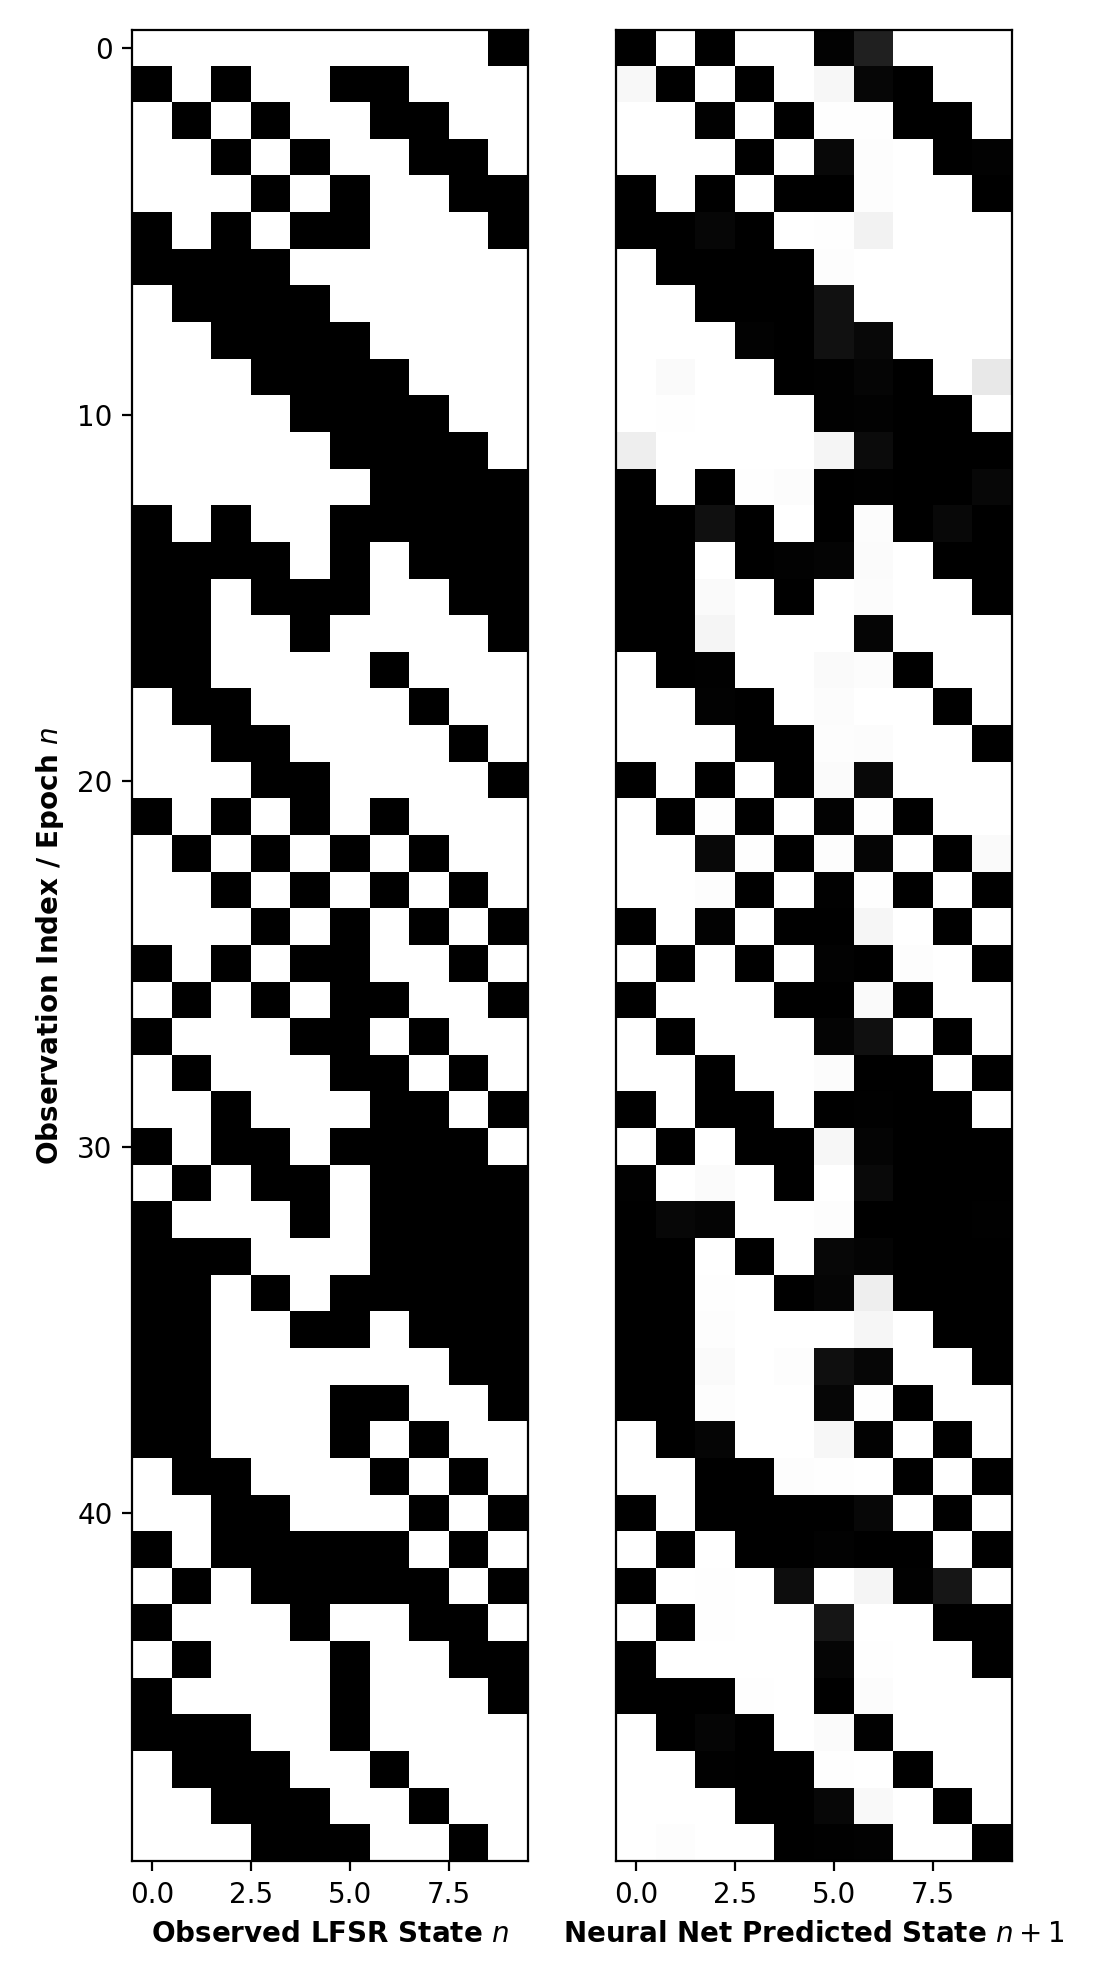

In [10]:
# Plot true n'th vs. predicted (n + 1)'st'...
if plot_prediction_masks:
    
    # Plot LFSR state progression & predicted progression (in parallel)
    true_vs_predicted_masks(idx0=0, idx1=50, input_obs=X,
                            output_activations=output_activations)

### $\textbf{Visualize Convergence of Metrics vs. Training Epoch}$

<IPython.core.display.Javascript object>


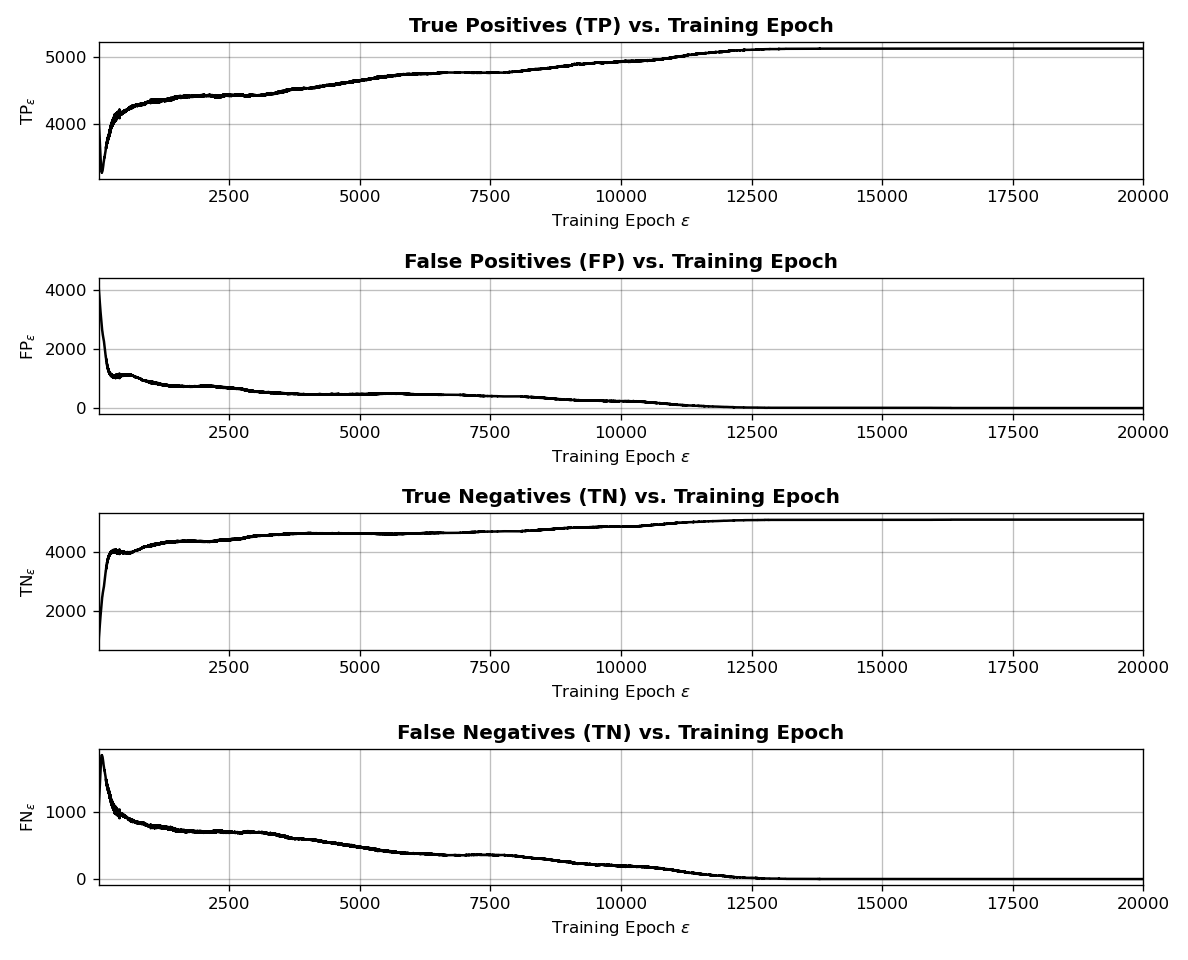

In [14]:
# Metrics plot enabled?...
if plot_metrics_versus_epoch:
    
    # Plot {TP,TN,FP,FN} vs. training epoch
    plot_metrics_vs_epoch(model_history, N_epoch)

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


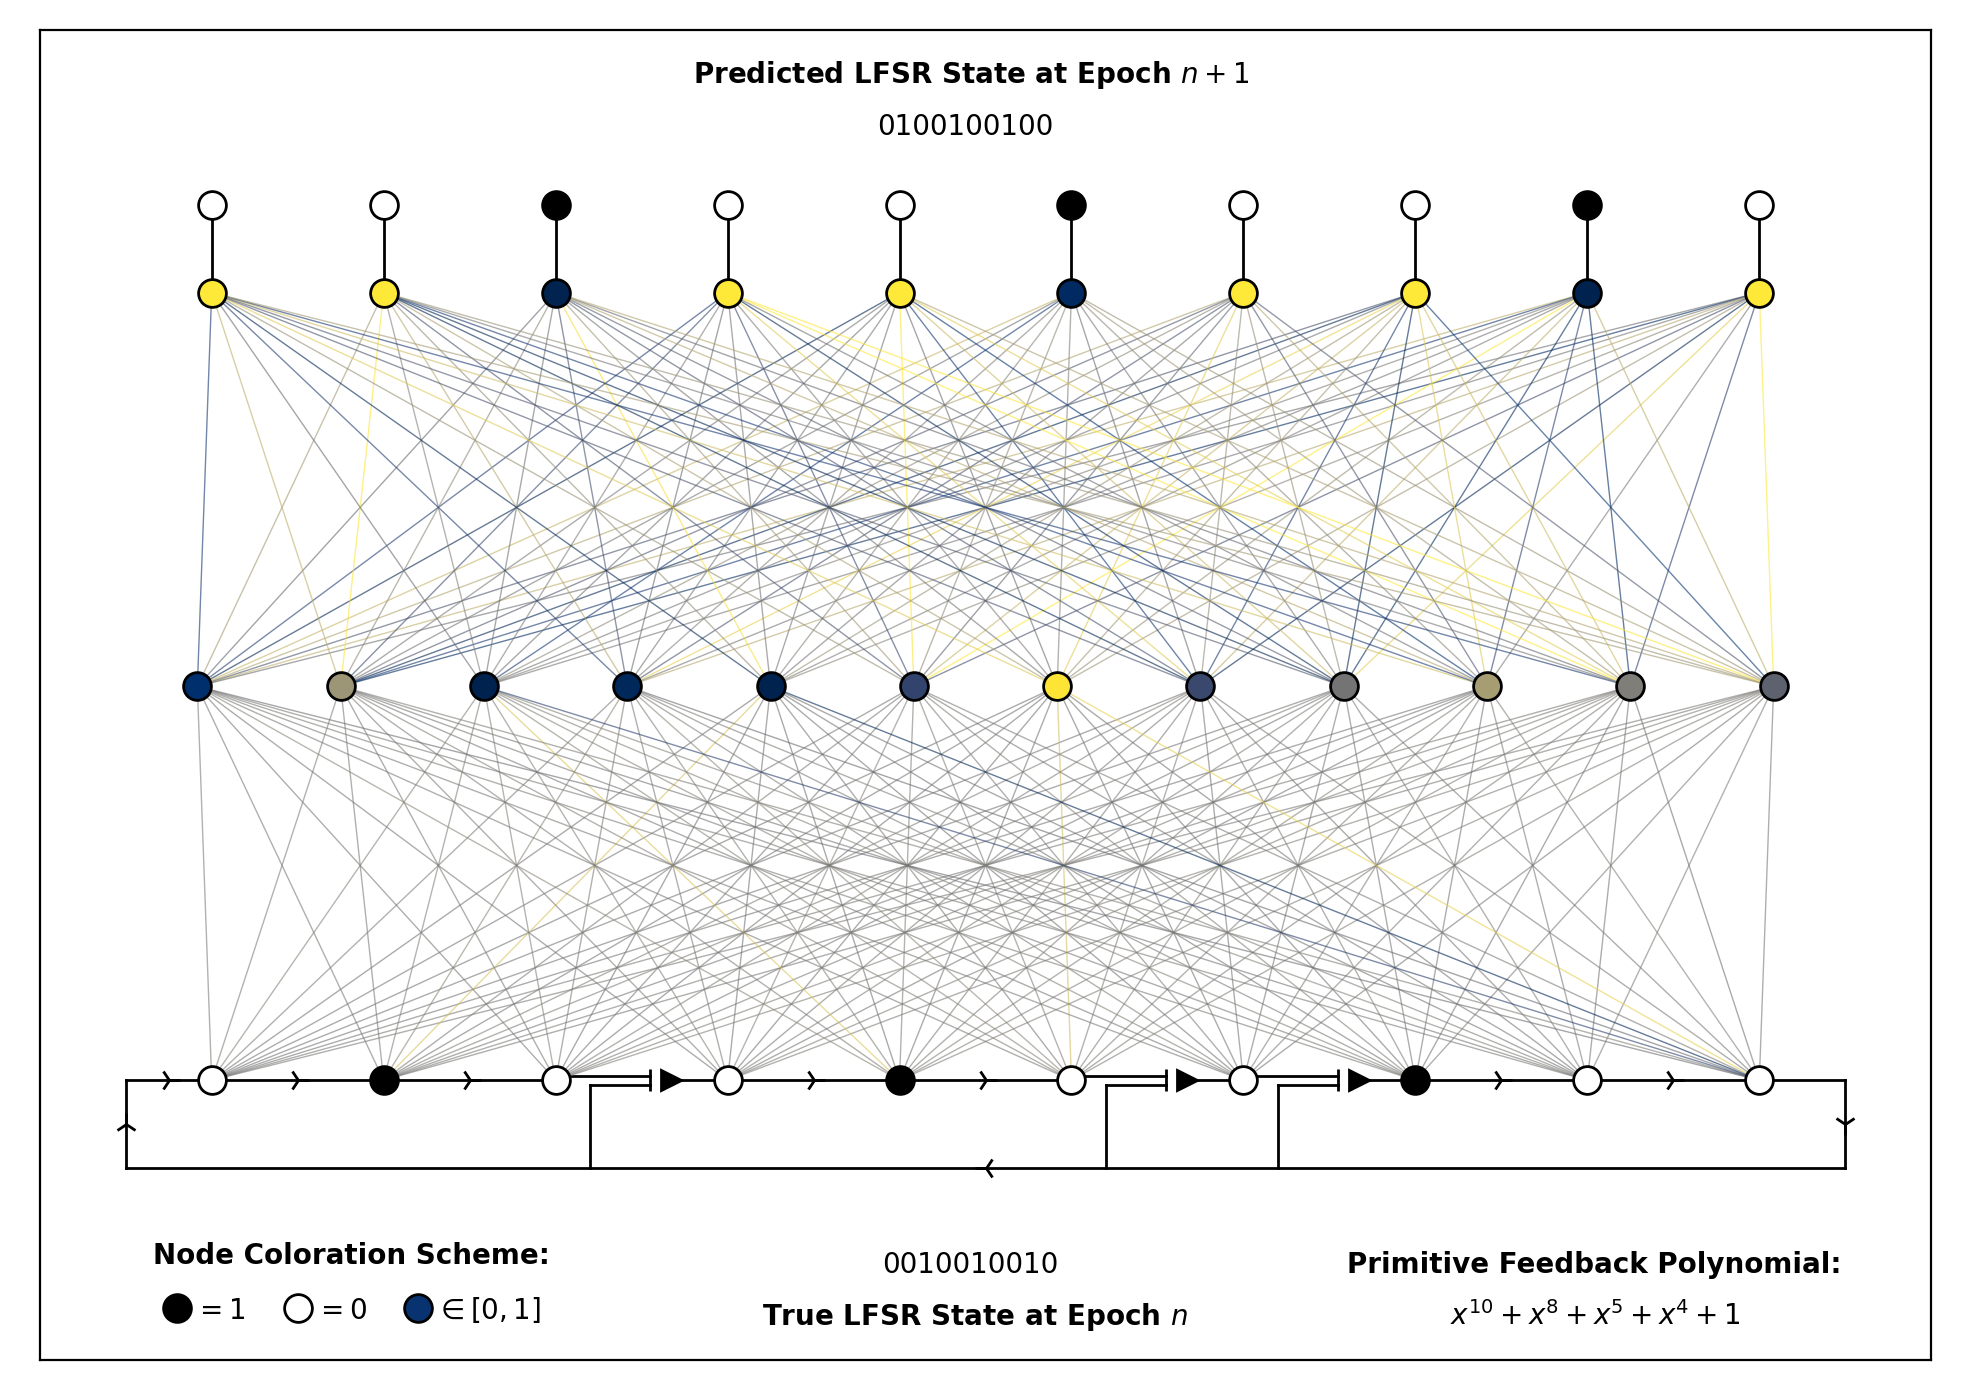

In [12]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 7),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'ylim': [-0.32, 1.2],
    'num_hidden': deg + 2,
    'num_input': deg,
    'num_output': deg,
    'node_size': 10,
    'link_width': 1,
    'net_link_alpha': 0.6,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

lfsr_prediction_animation(
    lfsr=LFSRs[p], config=config, model=model,
    state_sequence=X, hidden_activations=hidden_activations,
    output_activations=output_activations,
    run_animation=True, interval=1000, blit=True, repeat=True)